In [264]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [265]:
# Define a class to receive the characteristics of each object detection
class Detection():
    def __init__(self):
        # max number of rectangles history
        self.n_rects = 50
        
        # history of rectangles previous
        self.prev_rects = []

    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > self.n_rects:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-self.n_rects:]

Number of vehicle images found: 8792
Number of non-vehicle images found: 8968


(-0.5, 437.5, 239.5, -0.5)

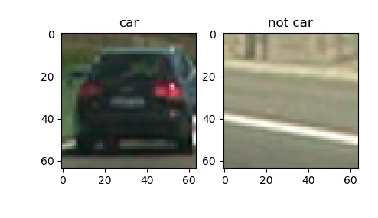

In [128]:
# Read in cars and notcars
    
# Load in the vehicle images to a list
vehicle_img_location = glob.glob('vehicles/*/*.png')
cars = []

# Read in a vehicle image
for f in vehicle_img_location:
    cars.append(f)
    
# Load in the non-vehicle images to a list
nonvehicle_img_location = glob.glob('non-vehicles/*/*.png')
notcars = []

# Read in a non-vehicle image
for f in nonvehicle_img_location:
    notcars.append(f)


print("Number of vehicle images found:", len(cars))
print("Number of non-vehicle images found:", len(notcars))

In [316]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                             pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                  pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        plt.axis('off')
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

    #plt.savefig('output_images/sliding_window_examples.jpg', dpi=100, bbox_inches='tight')

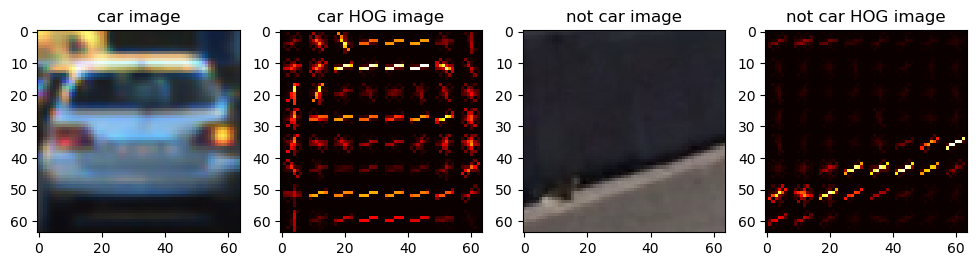

In [261]:
# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, or 2 for this cell 
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, 
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, 
                                                  vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, 
                                                  color_space=color_space, 
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, 
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, 
                                                  hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, 
                                                  hist_feat=hist_feat, 
                                                  hog_feat=hog_feat, 
                                                  vis=True)
                                                                                        
# Visualizer
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'not car image', 'not car HOG image']
fig = plt.figure(figsize=(12,3), dpi=100)
visualize(fig, 1, 4, images, titles)

In [ ]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
#n_samples = 1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(notcars)[random_idxs]
test_cars = cars 
test_notcars = notcars

car_features = extract_features(test_cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size, 
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_scaler = MinMaxScaler(feature_range=(0.1, 0.9)).fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
rand_state = 63
print("rand_state=", rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.25, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear Support Vector Classifier (SVC)
svc = LinearSVC(random_state=rand_state)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save model
data = {
    'svc': svc,
    'color_space': "YCrCb",
    'hog_channel': "ALL",
    'X_scaler': X_scaler,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins
}
#pickle.dump(data, open("model_svc.p", 'wb'))

In [273]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [293]:
# Load a pre-trained SVC model from a serialized (pickle) file
model = pickle.load(open("model_svc.p", "rb"))
# Get attributes of the SVC object
svc = model['svc']
color_space = model['color_space']
hog_channel = model['hog_channel']
X_scaler = model['X_scaler']
orient = model['orient']
pix_per_cell = model['pix_per_cell']
cell_per_block = model['cell_per_block']
spatial_size = model['spatial_size']
hist_bins = model['hist_bins']

# Threshold to determine the best predictions
classification_thresh = 0.33

# Single function to extract features and make predictions
def find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):

    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    
    # Make a heatmap of zeros
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    ctrans_to_search = convert_color(img_to_search, conv='RGB2YCrCb')
    if scale != 1:
        img_shape = ctrans_to_search.shape
        ctrans_to_search = cv2.resize(ctrans_to_search, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
        
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]        
    ch3 = ctrans_to_search[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step        
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell
            
            # Extract the sub-image patch
            sub_img = cv2.resize(ctrans_to_search[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # Get color features
            #spatial_features = bin_spatial(sub_img, size=spatial_size)
            hist_features = color_hist(sub_img, nbins=hist_bins)
            
            # Scale features and make a prediction            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1,-1))
            
            # Predict if there is a car or not
            test_prediction = svc.predict(test_features)
            
            # Predict confidence score for a sample
            # Distance of the sample 'test_features' to the separating hyperplane
            confidence_score = svc.decision_function(test_features)
            
            # Keep the best predictions to manage inevitable false positives
            if ((test_prediction == 1 and confidence_score > classification_thresh) or show_all_rectangles):
                #print(confidence_score)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [275]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 496
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)

print(len(rectangles), 'rectangles found in image')

8 rectangles found in image


In [276]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

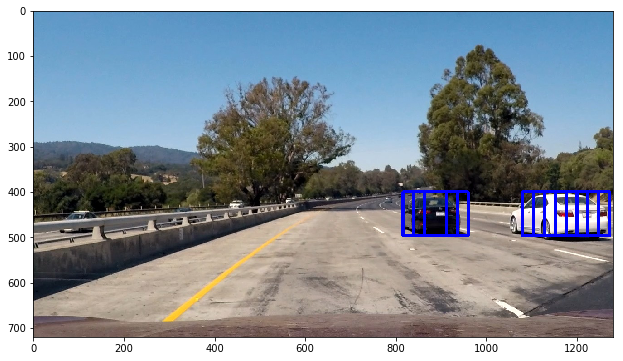

In [280]:
test_img = mpimg.imread('./test_images/test1.jpg')

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10.5, 6))
plt.imshow(test_img_rects)

Number of boxes (top row):  77
Number of boxes (bottom row):  77


Text(0.5,1,'Small Windows Near the Horizon (Scale=1.0)')

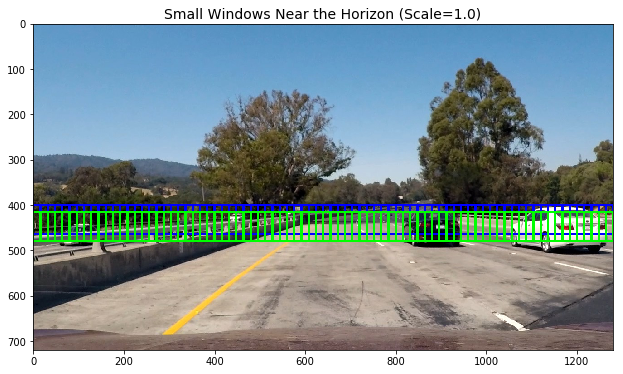

In [281]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row
rects = []
ystart = 400
ystop = 464  #480
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# bottom row, reset to visualize different color 
# show overlap of 75% between top and bottom rows
rects = []
ystart = 416 #420 start 25
ystop = 480  #500
scale = 1.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Small Windows Near the Horizon (Scale=1.0)', fontsize=14)
#plt.savefig('output_images/search_window_scale1.0.jpg', dpi=100, bbox_inches='tight')

Number of boxes (top row):  23
Number of boxes (bottom row):  23


Text(0.5,1,'Large Windows in the Center (Scale=3.0)')

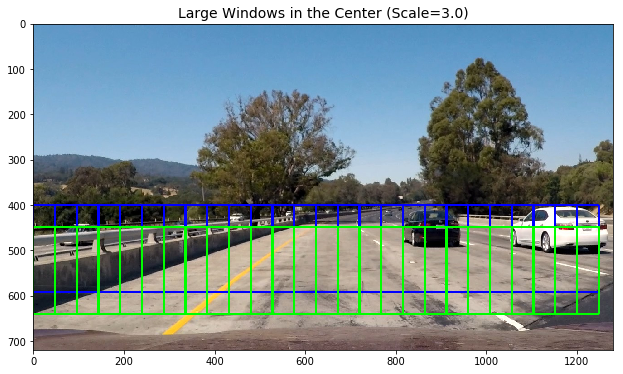

In [282]:
test_img = mpimg.imread('./test_images/test1.jpg')

# top row 
rects = []
ystart = 400
ystop = 592
scale = 3.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists and draw the rectangles
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes (top row): ', len(rectangles))
test_img = draw_boxes(test_img, rectangles, color=(0,0,255), thick=3)


# bottom row, reset to visualize different color
# show overlap of 75% between top and bottom rows
rects = []
ystart = 448
ystop = 640
scale = 3.0
r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
rects.append(r)

# flatten a list of lists  and draw the rectangles
rectangles = [item for sublist in rects for item in sublist]
print('Number of boxes (bottom row): ', len(rectangles))
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=3)
plt.figure(figsize=(10.5,6))
plt.imshow(test_img_rects)
plt.title('Large Windows in the Center (Scale=3.0)', fontsize=14)
#plt.savefig('output_images/search_window_scale3.0.jpg', dpi=100, bbox_inches='tight')

test_images/test6.jpg
test_images/test5.jpg
test_images/test4.jpg
test_images/test3.jpg
test_images/test2.jpg
test_images/test1.jpg


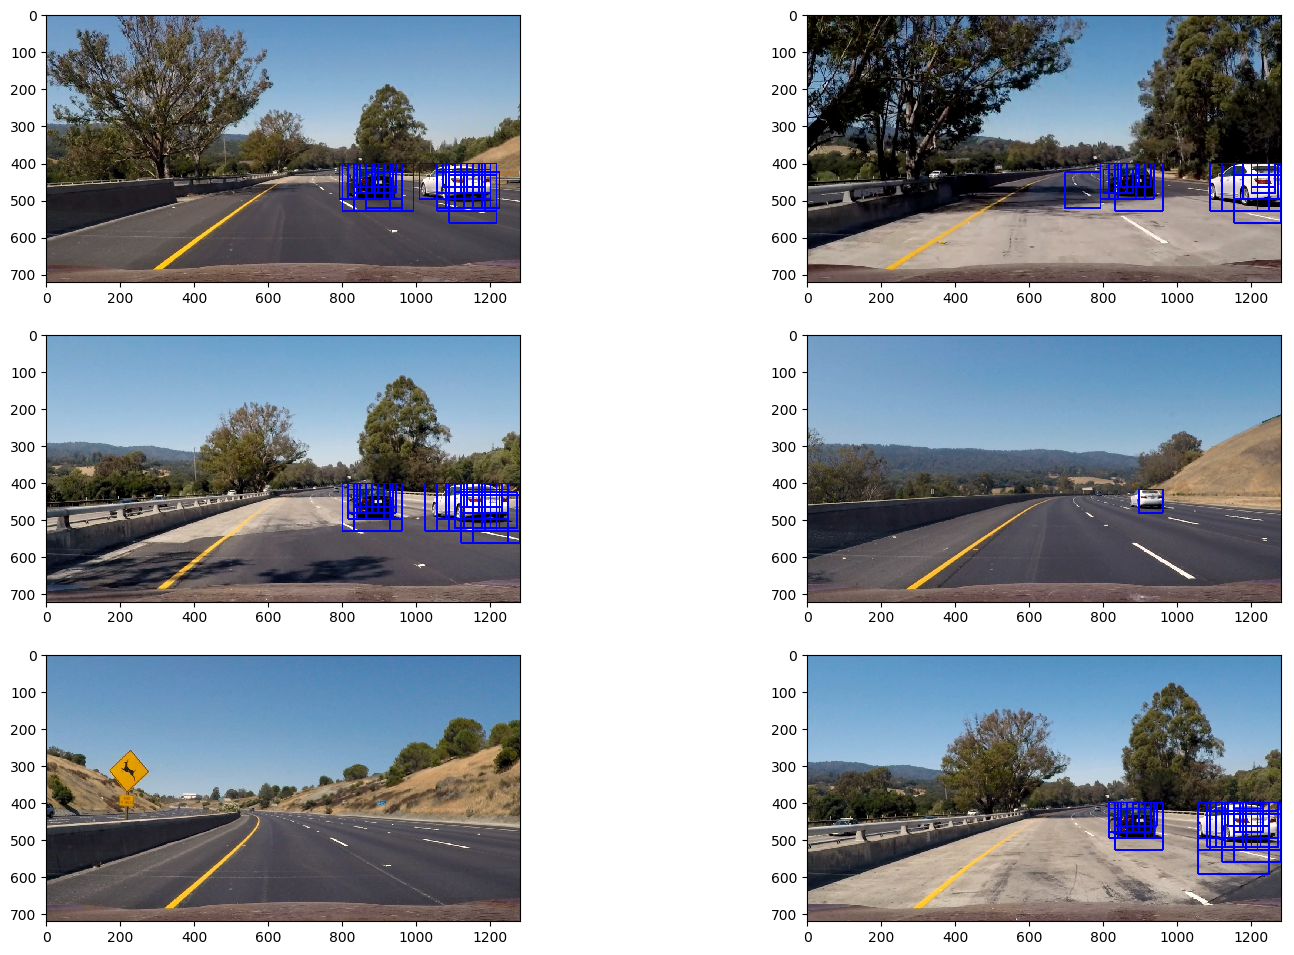

In [294]:
# Run find_cars multiple times to generate
# multi-scaled search windows (1, 1.5x, 2x, 3x)

search_path = 'test_images/*.jpg'
example_images = sorted(glob.glob(search_path), reverse=True)
images = []
titles = []
for img_src in example_images:
    print(img_src)
    t1 = time.time()
    test_img = mpimg.imread(img_src)

    rects = []
    ystart = 400
    ystop = 464
    scale = 1.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 416
    ystop = 480
    scale = 1.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)  


    ystart = 400
    ystop = 496
    scale = 1.5
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 424
    ystop = 520
    scale = 1.5
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 528
    scale = 2.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 560
    scale = 2.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 592
    scale = 3.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 448
    ystop = 640
    scale = 3.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)

    # flatten a list of lists
    rects = [item for sublist in rects for item in sublist] 

    test_img_rects = draw_boxes(test_img, rects, color=(0,0,255), thick=3)
    
    images.append(test_img_rects)
    titles.append('')
    
    #plt.figure(figsize=(10.5,6))
    #plt.imshow(test_img_rects)
    #print('Total Number of boxes: ', len(rects))
    
fig = plt.figure(figsize=(18,12), dpi=100)
visualize(fig, 3, 2, images, titles)

In [297]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

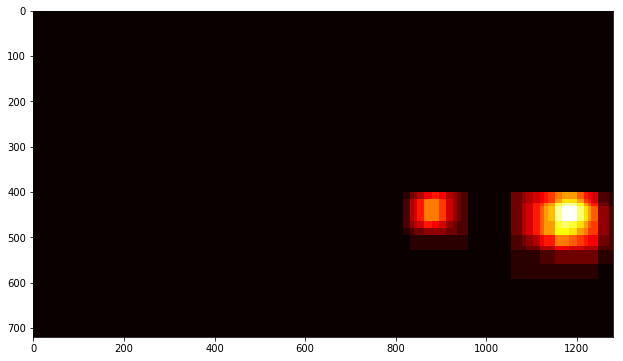

In [304]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rects)
plt.figure(figsize=(10.5, 6))
plt.imshow(heatmap_img, cmap='hot')

In [305]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

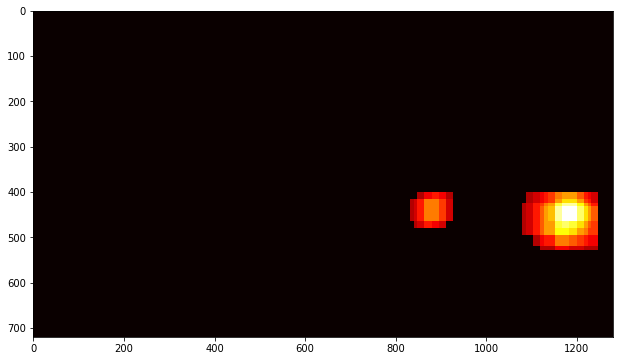

In [310]:
heatmap_thresh = apply_threshold(heatmap_img, 4)
plt.figure(figsize=(10.5, 6))
plt.imshow(heatmap_thresh, cmap='hot')

2 cars found


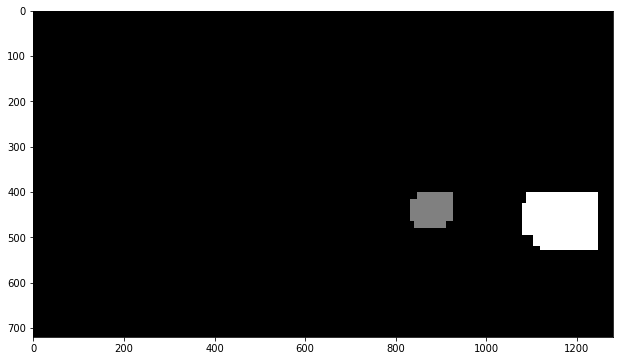

In [311]:
labels = label(heatmap_thresh)
plt.figure(figsize=(10.5, 6))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

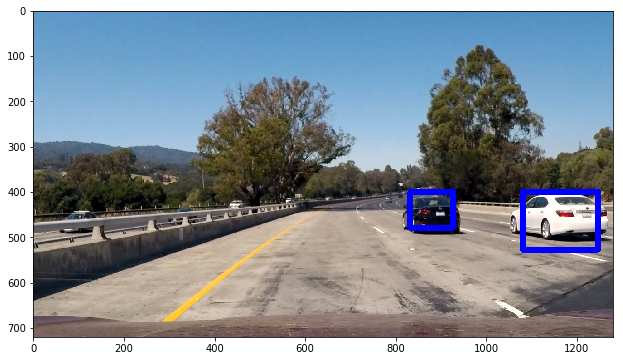

In [345]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 12)
        bboxes.append(bbox)

    # Return the image
    return img, bboxes

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10.5, 6))
plt.imshow(draw_img)
    

test_images/test1.jpg
(720, 1280) (720, 1280)


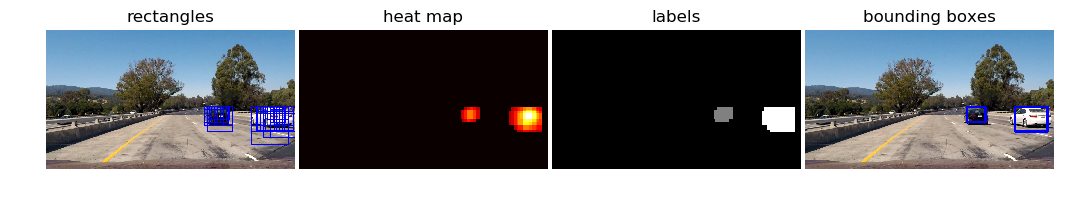

In [348]:
# Run find_cars multiple times to generate
# multi-scaled search windows (1, 1.5x, 2x, 3x)

search_path = 'test_images/test1.jpg'
example_images = sorted(glob.glob(search_path), reverse=True)
images = []
titles = []
for img_src in example_images:
    print(img_src)
    t1 = time.time()
    test_img = mpimg.imread(img_src)

    rects = []
    ystart = 400
    ystop = 464
    scale = 1.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 416
    ystop = 480
    scale = 1.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)  


    ystart = 400
    ystop = 496
    scale = 1.5
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 424
    ystop = 520
    scale = 1.5
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 528
    scale = 2.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 560
    scale = 2.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 592
    scale = 3.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 448
    ystop = 640
    scale = 3.0
    r = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)

    # flatten a list of lists
    rects = [item for sublist in rects for item in sublist] 

    test_img_rects = draw_boxes(test_img, rects, color=(0,0,255), thick=3)
    

    
    #plt.figure(figsize=(10.5,6))
    #plt.imshow(test_img_rects)
    #print('Total Number of boxes: ', len(rects))
    
    
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rects)
    #plt.figure(figsize=(10.5, 6))
    #plt.imshow(heatmap_img, cmap='hot')
    
    heatmap_thresh = apply_threshold(heatmap_img, 4)
    #plt.figure(figsize=(10.5, 6))
    #plt.imshow(heatmap_thresh, cmap='hot')
    
    labels = label(heatmap_thresh)
    #plt.figure(figsize=(10.5, 6))
    #plt.imshow(labels[0], cmap='gray')
    
    # Draw bounding boxes on a copy of the image
    draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
    # Display the image
    #plt.figure(figsize=(10.5, 6))
    #plt.imshow(draw_img)
    
    print(heatmap_img.shape, labels[0].shape)
    
    images.append(test_img_rects)
    titles.append('rectangles')

    images.append(heatmap_img)
    titles.append('heat map')
    
    images.append(labels[0])
    titles.append('labels')
    
    images.append(draw_img)
    titles.append('bounding boxes')
    
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(13,6), dpi=100)

rows=1
cols=4
imgs=images

# define a function for plotting multiple images
#def visualize(fig, rows, cols, imgs, titles):
for i, img in enumerate(imgs):
    
    plt.subplot(rows, cols, i+1)
    #ax1 = plt.subplot(rows, cols, gs1[i])
    plt.title(i+1)
    plt.axis('off')
    #print(i)
    
    if (i == 2):
        
        plt.imshow(img, cmap='gray')
        plt.title(titles[i])
    else:
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
    
plt.subplots_adjust(wspace=0.02, hspace=0)

plt.savefig('output_images/heatmap_bounding_boxes.jpg', dpi=100, bbox_inches='tight')


In [314]:
# Run find_cars multiple times to generate
# multi-scaled search windows (1, 1.5x, 2x, 3x)

def process_image(img):
    rects = []

    ystart = 400
    ystop = 464
    scale = 1.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 416
    ystop = 480
    scale = 1.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 496
    scale = 1.5
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 424 
    ystop = 520
    scale = 1.5
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 528
    scale = 2.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 432
    ystop = 560
    scale = 2.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                    pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 400
    ystop = 592
    scale = 3.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)


    ystart = 448
    ystop = 640
    scale = 3.0
    r = find_cars(img, ystart, ystop, scale, color_space, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False)
    rects.append(r)

    # flatten a list of lists..
    rects = [item for sublist in rects for item in sublist] 
    
    # add detections to the history
    if len(rects) > 0:
        det.add_rects(rects)
        
    # initialize the detection history
    if len(det.prev_rects) >= det.n_rects:
    
        heatmap_img = np.zeros_like(test_img[:,:,0])
    
        for rect_set in det.prev_rects:
            heatmap_img = add_heat(heatmap_img, rect_set)
        det_thresh = 1 + len(det.prev_rects) // 2
        heatmap_thresh = apply_threshold(heatmap_img, det_thresh)
    
        # To-do superimpose heatmap on upper left corner of draw_img/img..
        #median = cv2.medianBlur(heatmap_thresh, 11)
        #plt.figure(figsize=(10,10))
        #plt.imshow(heatmap_thresh, cmap='hot')
        
        labels = label(heatmap_thresh)
        draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img
    else:
        return img

In [254]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Class object for heat map
det = Detection()

test_output = 'output_video016a.mp4'
#clip = VideoFileClip("test_video.mp4")
#clip = VideoFileClip("project_video.mp4").subclip(0,11)
clip = VideoFileClip("project_video.mp4").subclip(0,11)

test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_video016.mp4
[MoviePy] Writing video output_video016.mp4


 16%|█▌        | 202/1261 [07:07<35:54,  2.03s/it]

26 [((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 16%|█▌        | 203/1261 [07:10<36:53,  2.09s/it]

26 [((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 16%|█▌        | 204/1261 [07:12<36:56,  2.10s/it]

26 [((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 16%|█▋        | 205/1261 [07:14<36:51,  2.09s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 16%|█▋        | 206/1261 [07:16<36:36,  2.08s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 16%|█▋        | 207/1261 [07:18<36:41,  2.09s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 16%|█▋        | 208/1261 [07:20<36:42,  2.09s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1152, 400), (1248, 496)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 209/1261 [07:22<36:19,  2.07s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1176, 400), (1272, 496)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 210/1261 [07:24<36:24,  2.08s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1176, 424), (1272, 520)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 211/1261 [07:26<36:26,  2.08s/it]

26 [((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1176, 400), (1272, 496)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 17%|█▋        | 212/1261 [07:28<36:31,  2.09s/it]

26 [((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 17%|█▋        | 213/1261 [07:30<36:26,  2.09s/it]

26 [((1152, 400), (1216, 464)), ((1200, 400), (1264, 464)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1176, 400), (1272, 496)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 17%|█▋        | 214/1261 [07:32<36:13,  2.08s/it]

26 [((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528))]


 17%|█▋        | 215/1261 [07:35<36:11,  2.08s/it]

26 [((1184, 400), (1248, 464)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 216/1261 [07:37<36:17,  2.08s/it]

26 [((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1184, 416), (1248, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 217/1261 [07:39<36:16,  2.08s/it]

26 [((1184, 400), (1248, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 218/1261 [07:41<36:17,  2.09s/it]

26 [((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 219/1261 [07:43<36:09,  2.08s/it]

26 [((1184, 400), (1248, 464)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 17%|█▋        | 220/1261 [07:45<36:21,  2.10s/it]

26 [((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 221/1261 [07:47<36:28,  2.10s/it]

26 [((1184, 400), (1248, 464)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 222/1261 [07:49<36:13,  2.09s/it]

26 [((1184, 400), (1248, 464)), ((1152, 416), (1216, 480)), ((1184, 416), (1248, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 223/1261 [07:51<36:05,  2.09s/it]

26 [((1184, 400), (1248, 464)), ((1152, 416), (1216, 480)), ((1168, 416), (1232, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 224/1261 [07:54<39:35,  2.29s/it]

26 [((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 225/1261 [07:57<42:07,  2.44s/it]

26 [((1136, 400), (1200, 464)), ((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1152, 400), (1280, 528))]


 18%|█▊        | 226/1261 [08:00<44:07,  2.56s/it]

26 [((1136, 400), (1200, 464)), ((1184, 400), (1248, 464)), ((1168, 416), (1232, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 227/1261 [08:02<43:15,  2.51s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1184, 416), (1248, 480)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1056, 424), (1152, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 228/1261 [08:04<41:20,  2.40s/it]

26 [((1168, 400), (1232, 464)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1056, 424), (1152, 520)), ((1152, 424), (1248, 520)), ((1152, 400), (1280, 528))]


 18%|█▊        | 229/1261 [08:06<39:21,  2.29s/it]

26 [((1168, 400), (1232, 464)), ((1152, 400), (1248, 496)), ((1056, 424), (1152, 520)), ((1152, 424), (1248, 520)), ((1152, 400), (1280, 528))]


 18%|█▊        | 230/1261 [08:08<38:13,  2.22s/it]

26 [((1168, 400), (1232, 464)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1152, 400), (1280, 528))]


 18%|█▊        | 231/1261 [08:10<37:28,  2.18s/it]

26 [((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 232/1261 [08:12<36:53,  2.15s/it]

26 [((1168, 400), (1232, 464)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 18%|█▊        | 233/1261 [08:15<36:18,  2.12s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▊        | 234/1261 [08:17<39:08,  2.29s/it]

26 [((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1152, 416), (1216, 480)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▊        | 235/1261 [08:20<39:13,  2.29s/it]

26 [((1168, 400), (1232, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▊        | 236/1261 [08:22<38:41,  2.27s/it]

26 [((1168, 400), (1232, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▉        | 237/1261 [08:24<38:27,  2.25s/it]

26 [((1168, 400), (1232, 464)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▉        | 238/1261 [08:26<38:49,  2.28s/it]

26 [((1120, 400), (1184, 464)), ((1168, 400), (1232, 464)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▉        | 239/1261 [08:28<37:55,  2.23s/it]

26 [((1120, 400), (1184, 464)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▉        | 240/1261 [08:31<37:15,  2.19s/it]

26 [((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 19%|█▉        | 241/1261 [08:33<36:29,  2.15s/it]

26 [((1152, 400), (1216, 464)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 19%|█▉        | 242/1261 [08:35<35:56,  2.12s/it]

26 [((1104, 400), (1168, 464)), ((1152, 400), (1216, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 19%|█▉        | 243/1261 [08:37<35:48,  2.11s/it]

26 [((80, 400), (144, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1120, 400), (1248, 528))]


 19%|█▉        | 244/1261 [08:39<35:46,  2.11s/it]

26 [((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1120, 400), (1248, 528))]


 19%|█▉        | 245/1261 [08:41<35:41,  2.11s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((144, 424), (240, 520)), ((168, 424), (264, 520)), ((1128, 424), (1224, 520)), ((1120, 400), (1248, 528))]


 20%|█▉        | 246/1261 [08:43<35:25,  2.09s/it]

26 [((64, 400), (128, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 20%|█▉        | 247/1261 [08:45<35:14,  2.09s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1152, 416), (1216, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 20%|█▉        | 248/1261 [08:47<35:25,  2.10s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((168, 424), (264, 520)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 20%|█▉        | 249/1261 [08:49<35:17,  2.09s/it]

26 [((1152, 400), (1216, 464)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]


 20%|█▉        | 250/1261 [08:51<35:11,  2.09s/it]

26 [((1152, 400), (1216, 464)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]


 20%|█▉        | 251/1261 [08:53<35:15,  2.09s/it]

26 [((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]


 20%|█▉        | 252/1261 [08:56<35:17,  2.10s/it]

26 [((1104, 400), (1168, 464)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]


 20%|██        | 253/1261 [08:58<35:09,  2.09s/it]

26 [((1104, 400), (1168, 464)), ((1136, 416), (1200, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1120, 400), (1248, 528))]


 20%|██        | 254/1261 [09:00<34:56,  2.08s/it]

26 [((1104, 400), (1168, 464)), ((1136, 416), (1200, 480)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528))]


 20%|██        | 255/1261 [09:02<34:53,  2.08s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1120, 400), (1248, 528))]


 20%|██        | 256/1261 [09:04<34:59,  2.09s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]


 20%|██        | 257/1261 [09:06<34:38,  2.07s/it]

26 [((1136, 400), (1200, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520))]


 20%|██        | 258/1261 [09:08<34:33,  2.07s/it]

26 [((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520))]


 21%|██        | 259/1261 [09:10<34:48,  2.08s/it]

26 [((1136, 400), (1200, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520))]


 21%|██        | 260/1261 [09:12<34:38,  2.08s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1120, 416), (1184, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1120, 400), (1248, 528))]


 21%|██        | 261/1261 [09:14<34:38,  2.08s/it]

26 [((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1120, 416), (1184, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1032, 424), (1128, 520)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 21%|██        | 262/1261 [09:16<34:28,  2.07s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1032, 424), (1128, 520)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 21%|██        | 263/1261 [09:18<34:24,  2.07s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1032, 424), (1128, 520)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 21%|██        | 264/1261 [09:20<34:38,  2.09s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528))]


 21%|██        | 265/1261 [09:23<34:31,  2.08s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]


 21%|██        | 266/1261 [09:25<34:31,  2.08s/it]

26 [((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 21%|██        | 267/1261 [09:27<34:37,  2.09s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]


 21%|██▏       | 268/1261 [09:29<34:46,  2.10s/it]

26 [((1136, 400), (1200, 464)), ((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]


 21%|██▏       | 269/1261 [09:31<34:40,  2.10s/it]

26 [((1072, 400), (1136, 464)), ((1136, 400), (1200, 464)), ((1104, 416), (1168, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 21%|██▏       | 270/1261 [09:33<34:26,  2.08s/it]

26 [((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 21%|██▏       | 271/1261 [09:35<34:15,  2.08s/it]

26 [((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 22%|██▏       | 272/1261 [09:37<34:19,  2.08s/it]

26 [((1136, 400), (1200, 464)), ((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 22%|██▏       | 273/1261 [09:39<34:10,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 22%|██▏       | 274/1261 [09:41<34:15,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 22%|██▏       | 275/1261 [09:43<34:18,  2.09s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 22%|██▏       | 276/1261 [09:46<34:22,  2.09s/it]

26 [((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528))]


 22%|██▏       | 277/1261 [09:48<34:06,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]


 22%|██▏       | 278/1261 [09:50<34:03,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 22%|██▏       | 279/1261 [09:52<34:30,  2.11s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]


 22%|██▏       | 280/1261 [09:55<37:57,  2.32s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]


 22%|██▏       | 281/1261 [09:57<40:10,  2.46s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]


 22%|██▏       | 282/1261 [10:00<40:33,  2.49s/it]

26 [((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1088, 400), (1216, 528))]


 22%|██▏       | 283/1261 [10:02<39:00,  2.39s/it]

26 [((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528))]


 23%|██▎       | 284/1261 [10:04<37:36,  2.31s/it]

26 [((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1024, 400), (1152, 528))]


 23%|██▎       | 285/1261 [10:06<36:29,  2.24s/it]

26 [((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520))]


 23%|██▎       | 286/1261 [10:08<35:27,  2.18s/it]

26 [((1120, 400), (1184, 464)), ((1104, 416), (1168, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520))]


 23%|██▎       | 287/1261 [10:11<35:16,  2.17s/it]

26 [((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1024, 400), (1152, 528))]


 23%|██▎       | 288/1261 [10:13<34:51,  2.15s/it]

26 [((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 424), (1176, 520)), ((1024, 400), (1152, 528))]


 23%|██▎       | 289/1261 [10:15<34:27,  2.13s/it]

26 [((1104, 400), (1168, 464)), ((1088, 416), (1152, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1088, 400), (1216, 528))]


 23%|██▎       | 290/1261 [10:17<34:08,  2.11s/it]

26 [((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1080, 424), (1176, 520))]


 23%|██▎       | 291/1261 [10:19<33:54,  2.10s/it]

26 [((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1088, 400), (1216, 528))]


 23%|██▎       | 292/1261 [10:21<34:04,  2.11s/it]

26 [((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1104, 416), (1168, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((704, 432), (832, 560))]


 23%|██▎       | 293/1261 [10:23<34:06,  2.11s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1072, 416), (1136, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1088, 400), (1216, 528))]


 23%|██▎       | 294/1261 [10:25<33:46,  2.10s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528))]


 23%|██▎       | 295/1261 [10:27<33:36,  2.09s/it]

26 [((1104, 400), (1168, 464)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1088, 400), (1216, 528))]


 23%|██▎       | 296/1261 [10:29<33:18,  2.07s/it]

26 [((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528))]


 24%|██▎       | 297/1261 [10:31<33:11,  2.07s/it]

26 [((1104, 400), (1168, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528))]


 24%|██▎       | 298/1261 [10:33<33:12,  2.07s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528))]


 24%|██▎       | 299/1261 [10:35<33:17,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 300/1261 [10:38<33:06,  2.07s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1088, 416), (1152, 480)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1088, 400), (1216, 528))]


 24%|██▍       | 301/1261 [10:40<32:57,  2.06s/it]

26 [((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 302/1261 [10:42<33:09,  2.07s/it]

26 [((1104, 400), (1168, 464)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 303/1261 [10:44<33:18,  2.09s/it]

26 [((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1056, 416), (1120, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 304/1261 [10:46<33:05,  2.07s/it]

26 [((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 305/1261 [10:48<32:50,  2.06s/it]

26 [((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 306/1261 [10:50<33:01,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 307/1261 [10:52<33:11,  2.09s/it]

26 [((1040, 400), (1104, 464)), ((1088, 400), (1152, 464)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 24%|██▍       | 308/1261 [10:54<33:13,  2.09s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 25%|██▍       | 309/1261 [10:56<32:59,  2.08s/it]

26 [((1088, 400), (1152, 464)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 25%|██▍       | 310/1261 [10:58<32:51,  2.07s/it]

26 [((1088, 400), (1152, 464)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 25%|██▍       | 311/1261 [11:00<32:44,  2.07s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 25%|██▍       | 312/1261 [11:02<32:43,  2.07s/it]

26 [((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 25%|██▍       | 313/1261 [11:04<32:36,  2.06s/it]

26 [((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 25%|██▍       | 314/1261 [11:07<32:54,  2.09s/it]

26 [((448, 416), (512, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 25%|██▍       | 315/1261 [11:09<33:00,  2.09s/it]

26 [((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 25%|██▌       | 316/1261 [11:11<33:06,  2.10s/it]

26 [((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 25%|██▌       | 317/1261 [11:13<32:53,  2.09s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((992, 400), (1120, 528))]


 25%|██▌       | 318/1261 [11:15<33:19,  2.12s/it]

26 [((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1088, 400), (1216, 528))]


 25%|██▌       | 319/1261 [11:17<32:56,  2.10s/it]

26 [((1088, 400), (1152, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 25%|██▌       | 320/1261 [11:19<32:41,  2.08s/it]

26 [((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 25%|██▌       | 321/1261 [11:21<32:37,  2.08s/it]

26 [((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528))]


 26%|██▌       | 322/1261 [11:23<32:40,  2.09s/it]

26 [((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 26%|██▌       | 323/1261 [11:25<32:35,  2.09s/it]

26 [((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 26%|██▌       | 324/1261 [11:28<32:35,  2.09s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1056, 400), (1184, 528))]


 26%|██▌       | 325/1261 [11:30<34:20,  2.20s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1056, 424), (1152, 520)), ((1056, 400), (1184, 528))]


 26%|██▌       | 326/1261 [11:32<34:43,  2.23s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 424), (1152, 520)), ((1056, 400), (1184, 528))]


 26%|██▌       | 327/1261 [11:34<33:59,  2.18s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 424), (1152, 520))]


 26%|██▌       | 328/1261 [11:36<33:31,  2.16s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496))]


 26%|██▌       | 329/1261 [11:39<32:58,  2.12s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1072, 416), (1136, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 424), (1152, 520))]


 26%|██▌       | 330/1261 [11:41<32:53,  2.12s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496))]


 26%|██▌       | 331/1261 [11:43<32:35,  2.10s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 400), (1184, 528))]


 26%|██▋       | 332/1261 [11:45<32:22,  2.09s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 400), (1184, 528))]


 26%|██▋       | 333/1261 [11:47<34:48,  2.25s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 400), (1184, 528))]


 26%|██▋       | 334/1261 [11:50<34:59,  2.26s/it]

26 [((1056, 400), (1120, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((312, 424), (408, 520)), ((1056, 400), (1184, 528))]


 27%|██▋       | 335/1261 [11:54<42:28,  2.75s/it]

26 [((1056, 400), (1120, 464)), ((1040, 416), (1104, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 400), (1184, 528))]


 27%|██▋       | 336/1261 [11:56<39:31,  2.56s/it]

26 [((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1040, 416), (1104, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 424), (1152, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 27%|██▋       | 337/1261 [11:58<37:25,  2.43s/it]

26 [((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((96, 432), (224, 560))]


 27%|██▋       | 338/1261 [12:00<35:12,  2.29s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528))]


 27%|██▋       | 339/1261 [12:02<33:42,  2.19s/it]

26 [((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((312, 400), (408, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1056, 400), (1184, 528))]


 27%|██▋       | 340/1261 [12:04<32:11,  2.10s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520)), ((992, 400), (1120, 528))]


 27%|██▋       | 341/1261 [12:05<30:57,  2.02s/it]

26 [((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520))]


 27%|██▋       | 342/1261 [12:07<30:19,  1.98s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496))]


 27%|██▋       | 343/1261 [12:09<29:59,  1.96s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520))]


 27%|██▋       | 344/1261 [12:11<29:26,  1.93s/it]

26 [((1040, 400), (1104, 464)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496))]


 27%|██▋       | 345/1261 [12:13<29:03,  1.90s/it]

26 [((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 424), (1128, 520))]


 27%|██▋       | 346/1261 [12:15<28:59,  1.90s/it]

26 [((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520))]


 28%|██▊       | 347/1261 [12:17<28:49,  1.89s/it]

26 [((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520))]


 28%|██▊       | 348/1261 [12:19<28:30,  1.87s/it]

26 [((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520))]


 28%|██▊       | 349/1261 [12:20<28:35,  1.88s/it]

26 [((1040, 400), (1104, 464)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 424), (1128, 520))]


 28%|██▊       | 350/1261 [12:22<28:24,  1.87s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 28%|██▊       | 351/1261 [12:24<28:15,  1.86s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496))]


 28%|██▊       | 352/1261 [12:26<28:17,  1.87s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496))]


 28%|██▊       | 353/1261 [12:28<28:09,  1.86s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((720, 424), (816, 520))]


 28%|██▊       | 354/1261 [12:30<28:09,  1.86s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496))]


 28%|██▊       | 355/1261 [12:32<28:13,  1.87s/it]

26 [((1040, 400), (1104, 464)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 28%|██▊       | 356/1261 [12:33<27:59,  1.86s/it]

26 [((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496))]


 28%|██▊       | 357/1261 [12:35<27:58,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 28%|██▊       | 358/1261 [12:37<28:10,  1.87s/it]

26 [((1024, 400), (1088, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1024, 400), (1152, 528))]


 28%|██▊       | 359/1261 [12:39<28:03,  1.87s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((744, 400), (840, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((720, 424), (816, 520)), ((1032, 424), (1128, 520))]


 29%|██▊       | 360/1261 [12:41<27:54,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520))]


 29%|██▊       | 361/1261 [12:43<27:57,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1040, 416), (1104, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496))]


 29%|██▊       | 362/1261 [12:45<27:57,  1.87s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520))]


 29%|██▉       | 363/1261 [12:47<27:54,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496))]


 29%|██▉       | 364/1261 [12:48<27:50,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496))]


 29%|██▉       | 365/1261 [12:50<27:45,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1008, 424), (1104, 520))]


 29%|██▉       | 366/1261 [12:52<27:48,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 29%|██▉       | 367/1261 [12:54<27:46,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 29%|██▉       | 368/1261 [12:56<27:35,  1.85s/it]

26 [((1024, 400), (1088, 464)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 29%|██▉       | 369/1261 [12:58<27:32,  1.85s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1024, 416), (1088, 480)), ((288, 400), (384, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((288, 424), (384, 520)), ((336, 424), (432, 520)), ((360, 424), (456, 520)), ((960, 400), (1088, 528))]


 29%|██▉       | 370/1261 [12:59<27:33,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528))]


 29%|██▉       | 371/1261 [13:01<27:32,  1.86s/it]

26 [((1024, 400), (1088, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528))]


 30%|██▉       | 372/1261 [13:03<27:25,  1.85s/it]

26 [((1008, 400), (1072, 464)), ((576, 416), (640, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((552, 400), (648, 496)), ((576, 400), (672, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((960, 400), (1088, 528))]


 30%|██▉       | 373/1261 [13:05<27:26,  1.85s/it]

26 [((1008, 400), (1072, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))]


 30%|██▉       | 374/1261 [13:07<27:25,  1.85s/it]

26 [((1008, 400), (1072, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))]


 30%|██▉       | 375/1261 [13:09<27:19,  1.85s/it]

26 [((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 30%|██▉       | 376/1261 [13:11<27:26,  1.86s/it]

26 [((1008, 400), (1072, 464)), ((976, 416), (1040, 480))]


 30%|██▉       | 377/1261 [13:12<27:18,  1.85s/it]

26 [((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496))]


 30%|██▉       | 378/1261 [13:14<27:30,  1.87s/it]

26 [((1008, 400), (1072, 464)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480))]


 30%|███       | 379/1261 [13:16<27:20,  1.86s/it]

26 [((1008, 400), (1072, 464)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 424), (1080, 520))]


 30%|███       | 380/1261 [13:18<27:20,  1.86s/it]

26 [((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((984, 424), (1080, 520))]


 30%|███       | 381/1261 [13:20<27:04,  1.85s/it]

26 [((992, 400), (1056, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((984, 424), (1080, 520))]


 30%|███       | 382/1261 [13:22<27:10,  1.86s/it]

26 [((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((984, 424), (1080, 520))]


 30%|███       | 383/1261 [13:24<27:06,  1.85s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 30%|███       | 384/1261 [13:25<26:58,  1.85s/it]

26 [((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496))]


 31%|███       | 385/1261 [13:27<27:02,  1.85s/it]

26 [((992, 400), (1056, 464)), ((992, 416), (1056, 480)), ((984, 400), (1080, 496))]


 31%|███       | 386/1261 [13:29<27:01,  1.85s/it]

26 [((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((984, 400), (1080, 496))]


 31%|███       | 387/1261 [13:31<26:57,  1.85s/it]

26 [((992, 400), (1056, 464)), ((992, 416), (1056, 480)), ((984, 400), (1080, 496))]


 31%|███       | 388/1261 [13:33<26:53,  1.85s/it]

26 [((992, 400), (1056, 464)), ((992, 416), (1056, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 31%|███       | 389/1261 [13:35<26:43,  1.84s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496))]


 31%|███       | 390/1261 [13:37<26:52,  1.85s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 31%|███       | 391/1261 [13:38<26:48,  1.85s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 31%|███       | 392/1261 [13:40<26:42,  1.84s/it]

26 [((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 31%|███       | 393/1261 [13:42<26:45,  1.85s/it]

26 [((976, 400), (1040, 464)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 31%|███       | 394/1261 [13:44<26:49,  1.86s/it]

26 [((976, 400), (1040, 464)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 31%|███▏      | 395/1261 [13:46<26:56,  1.87s/it]

26 [((976, 400), (1040, 464)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((528, 424), (624, 520))]


 31%|███▏      | 396/1261 [13:48<26:50,  1.86s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((600, 424), (696, 520))]


 31%|███▏      | 397/1261 [13:50<26:54,  1.87s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496)), ((600, 424), (696, 520))]


 32%|███▏      | 398/1261 [13:52<27:07,  1.89s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496))]


 32%|███▏      | 399/1261 [13:54<28:02,  1.95s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496))]


 32%|███▏      | 400/1261 [13:56<29:21,  2.05s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496))]


 32%|███▏      | 401/1261 [13:58<29:41,  2.07s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496))]


 32%|███▏      | 402/1261 [14:00<29:10,  2.04s/it]

26 [((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((960, 400), (1056, 496))]


 32%|███▏      | 403/1261 [14:02<28:47,  2.01s/it]

26 [((960, 400), (1024, 464)), ((960, 400), (1056, 496))]


 32%|███▏      | 404/1261 [14:04<28:06,  1.97s/it]

26 [((960, 400), (1024, 464)), ((960, 400), (1056, 496))]


 32%|███▏      | 405/1261 [14:06<27:34,  1.93s/it]

26 [((960, 400), (1024, 464))]


 32%|███▏      | 406/1261 [14:07<27:12,  1.91s/it]

26 [((960, 400), (1024, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480))]


 32%|███▏      | 407/1261 [14:09<27:00,  1.90s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480))]


 32%|███▏      | 408/1261 [14:11<26:56,  1.90s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480))]


 32%|███▏      | 409/1261 [14:13<26:45,  1.88s/it]

26 [((960, 400), (1024, 464)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480))]


 33%|███▎      | 410/1261 [14:15<26:31,  1.87s/it]

26 [((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496))]


 33%|███▎      | 411/1261 [14:17<26:28,  1.87s/it]

26 [((960, 416), (1024, 480))]


 33%|███▎      | 412/1261 [14:19<26:19,  1.86s/it]

26 [((960, 416), (1024, 480)), ((936, 400), (1032, 496))]


 33%|███▎      | 413/1261 [14:20<26:10,  1.85s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((936, 400), (1032, 496))]


 33%|███▎      | 414/1261 [14:22<26:18,  1.86s/it]

26 [((960, 416), (1024, 480)), ((936, 400), (1032, 496))]


 33%|███▎      | 415/1261 [14:24<26:19,  1.87s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]


 33%|███▎      | 416/1261 [14:26<26:12,  1.86s/it]

26 [((928, 400), (992, 464)), ((960, 400), (1024, 464))]


 33%|███▎      | 417/1261 [14:28<26:01,  1.85s/it]

26 []


 33%|███▎      | 418/1261 [14:30<26:06,  1.86s/it]

26 [((928, 400), (992, 464)), ((960, 400), (1024, 464))]


 33%|███▎      | 419/1261 [14:32<26:00,  1.85s/it]

26 [((928, 400), (992, 464)), ((960, 416), (1024, 480)), ((960, 400), (1056, 496))]


 33%|███▎      | 420/1261 [14:33<25:51,  1.84s/it]

26 [((936, 400), (1032, 496))]


 33%|███▎      | 421/1261 [14:35<25:54,  1.85s/it]

26 [((960, 400), (1024, 464))]


 33%|███▎      | 422/1261 [14:37<25:55,  1.85s/it]

26 []


 34%|███▎      | 423/1261 [14:39<25:48,  1.85s/it]

26 [((944, 416), (1008, 480)), ((960, 416), (1024, 480))]


 34%|███▎      | 424/1261 [14:41<25:41,  1.84s/it]

26 [((960, 416), (1024, 480)), ((936, 400), (1032, 496))]


 34%|███▎      | 425/1261 [14:43<25:40,  1.84s/it]

26 [((944, 416), (1008, 480)), ((936, 400), (1032, 496))]


 34%|███▍      | 426/1261 [14:45<25:43,  1.85s/it]

26 [((944, 416), (1008, 480))]


 34%|███▍      | 427/1261 [14:46<25:40,  1.85s/it]

26 [((936, 400), (1032, 496)), ((288, 424), (384, 520))]


 34%|███▍      | 428/1261 [14:48<25:43,  1.85s/it]

26 [((928, 416), (992, 480)), ((720, 424), (816, 520))]


 34%|███▍      | 429/1261 [14:50<25:33,  1.84s/it]

26 [((928, 416), (992, 480))]


 34%|███▍      | 430/1261 [14:52<25:34,  1.85s/it]

26 []


 34%|███▍      | 431/1261 [14:54<25:30,  1.84s/it]

26 [((944, 400), (1008, 464)), ((944, 416), (1008, 480))]


 34%|███▍      | 432/1261 [14:56<25:24,  1.84s/it]

26 [((944, 400), (1008, 464)), ((944, 416), (1008, 480))]


 34%|███▍      | 433/1261 [14:57<25:23,  1.84s/it]

26 [((944, 416), (1008, 480))]


 34%|███▍      | 434/1261 [14:59<25:39,  1.86s/it]

26 [((944, 400), (1008, 464)), ((928, 416), (992, 480)), ((944, 416), (1008, 480))]


 34%|███▍      | 435/1261 [15:01<25:37,  1.86s/it]

26 [((928, 400), (992, 464)), ((944, 400), (1008, 464)), ((944, 416), (1008, 480))]


 35%|███▍      | 436/1261 [15:03<25:28,  1.85s/it]

26 [((944, 400), (1008, 464))]


 35%|███▍      | 437/1261 [15:05<25:20,  1.85s/it]

26 [((912, 416), (976, 480)), ((936, 400), (1032, 496))]


 35%|███▍      | 438/1261 [15:07<25:25,  1.85s/it]

26 []


 35%|███▍      | 439/1261 [15:09<25:25,  1.86s/it]

26 []


 35%|███▍      | 440/1261 [15:10<25:25,  1.86s/it]

26 []


 35%|███▍      | 441/1261 [15:12<25:33,  1.87s/it]

26 [((944, 400), (1008, 464))]


 35%|███▌      | 442/1261 [15:14<25:33,  1.87s/it]

26 [((936, 400), (1032, 496))]


 35%|███▌      | 443/1261 [15:16<25:44,  1.89s/it]

26 [((944, 400), (1008, 464)), ((936, 400), (1032, 496))]


 35%|███▌      | 444/1261 [15:18<26:35,  1.95s/it]

26 [((944, 400), (1008, 464)), ((936, 400), (1032, 496))]


 35%|███▌      | 445/1261 [15:20<26:39,  1.96s/it]

26 [((944, 400), (1008, 464))]


 35%|███▌      | 446/1261 [15:23<27:42,  2.04s/it]

26 [((944, 400), (1008, 464))]


 35%|███▌      | 447/1261 [15:25<27:31,  2.03s/it]

26 [((944, 400), (1008, 464))]


 36%|███▌      | 448/1261 [15:26<27:08,  2.00s/it]

26 []


 36%|███▌      | 449/1261 [15:28<26:32,  1.96s/it]

26 [((936, 400), (1032, 496))]


 36%|███▌      | 450/1261 [15:30<26:03,  1.93s/it]

26 [((912, 400), (1008, 496)), ((936, 400), (1032, 496))]


 36%|███▌      | 451/1261 [15:32<25:40,  1.90s/it]

26 [((936, 400), (1032, 496))]


 36%|███▌      | 452/1261 [15:34<25:26,  1.89s/it]

26 [((936, 400), (1032, 496))]


 36%|███▌      | 453/1261 [15:36<25:19,  1.88s/it]

26 [((936, 400), (1032, 496))]


 36%|███▌      | 454/1261 [15:38<25:11,  1.87s/it]

26 []


 36%|███▌      | 455/1261 [15:39<24:56,  1.86s/it]

26 [((912, 400), (1008, 496))]


 36%|███▌      | 456/1261 [15:41<24:59,  1.86s/it]

26 []


 36%|███▌      | 457/1261 [15:43<24:57,  1.86s/it]

26 [((928, 416), (992, 480)), ((576, 424), (672, 520)), ((696, 424), (792, 520))]


 36%|███▋      | 458/1261 [15:45<24:58,  1.87s/it]

26 []


 36%|███▋      | 459/1261 [15:47<24:50,  1.86s/it]

26 [((896, 416), (960, 480))]


 36%|███▋      | 460/1261 [15:49<24:49,  1.86s/it]

26 [((928, 416), (992, 480))]


 37%|███▋      | 461/1261 [15:51<24:41,  1.85s/it]

26 [((896, 416), (960, 480)), ((928, 416), (992, 480)), ((576, 424), (672, 520))]


 37%|███▋      | 462/1261 [15:52<24:50,  1.87s/it]

26 [((936, 400), (1032, 496))]


 37%|███▋      | 463/1261 [15:54<24:48,  1.86s/it]

26 [((928, 400), (992, 464)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((936, 400), (1032, 496))]


 37%|███▋      | 464/1261 [15:56<24:45,  1.86s/it]

26 [((896, 416), (960, 480)), ((928, 416), (992, 480)), ((936, 400), (1032, 496))]


 37%|███▋      | 465/1261 [15:58<24:36,  1.85s/it]

26 [((896, 416), (960, 480)), ((928, 416), (992, 480))]


 37%|███▋      | 466/1261 [16:00<24:38,  1.86s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((792, 424), (888, 520))]


 37%|███▋      | 467/1261 [16:02<24:35,  1.86s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480))]


 37%|███▋      | 468/1261 [16:04<24:33,  1.86s/it]

26 [((912, 416), (976, 480)), ((928, 416), (992, 480))]


 37%|███▋      | 469/1261 [16:05<24:29,  1.86s/it]

26 [((896, 416), (960, 480)), ((928, 416), (992, 480))]


 37%|███▋      | 470/1261 [16:07<24:29,  1.86s/it]

26 []


 37%|███▋      | 471/1261 [16:09<24:24,  1.85s/it]

26 [((896, 416), (960, 480)), ((928, 416), (992, 480))]


 37%|███▋      | 472/1261 [16:11<24:19,  1.85s/it]

26 [((896, 416), (960, 480))]


 38%|███▊      | 473/1261 [16:13<24:15,  1.85s/it]

26 [((928, 416), (992, 480)), ((936, 400), (1032, 496))]


 38%|███▊      | 474/1261 [16:15<24:21,  1.86s/it]

26 [((928, 416), (992, 480)), ((936, 400), (1032, 496))]


 38%|███▊      | 475/1261 [16:17<24:15,  1.85s/it]

26 [((928, 416), (992, 480)), ((936, 400), (1032, 496)), ((840, 424), (936, 520))]


 38%|███▊      | 476/1261 [16:18<24:12,  1.85s/it]

26 [((912, 416), (976, 480)), ((928, 416), (992, 480)), ((936, 400), (1032, 496))]


 38%|███▊      | 477/1261 [16:20<24:11,  1.85s/it]

26 [((936, 400), (1032, 496))]


 38%|███▊      | 478/1261 [16:22<24:14,  1.86s/it]

26 [((936, 400), (1032, 496))]


 38%|███▊      | 479/1261 [16:24<24:11,  1.86s/it]

26 []


 38%|███▊      | 480/1261 [16:26<24:10,  1.86s/it]

26 [((928, 400), (992, 464)), ((912, 416), (976, 480))]


 38%|███▊      | 481/1261 [16:28<24:03,  1.85s/it]

26 [((928, 400), (992, 464)), ((928, 416), (992, 480))]


 38%|███▊      | 482/1261 [16:30<24:34,  1.89s/it]

26 [((928, 400), (992, 464))]


 38%|███▊      | 483/1261 [16:32<24:44,  1.91s/it]

26 [((928, 400), (992, 464))]


 38%|███▊      | 484/1261 [16:33<24:27,  1.89s/it]

26 [((928, 400), (992, 464)), ((928, 416), (992, 480))]


 38%|███▊      | 485/1261 [16:35<24:13,  1.87s/it]

26 [((928, 400), (992, 464)), ((928, 416), (992, 480))]


 39%|███▊      | 486/1261 [16:37<24:11,  1.87s/it]

26 [((928, 400), (992, 464))]


 39%|███▊      | 487/1261 [16:39<24:00,  1.86s/it]

26 [((928, 400), (992, 464))]


 39%|███▊      | 488/1261 [16:41<24:08,  1.87s/it]

26 [((928, 400), (992, 464)), ((928, 416), (992, 480))]


 39%|███▉      | 489/1261 [16:43<24:05,  1.87s/it]

26 [((928, 416), (992, 480)), ((888, 400), (984, 496))]


 39%|███▉      | 490/1261 [16:45<23:57,  1.86s/it]

26 [((928, 400), (992, 464))]


 39%|███▉      | 491/1261 [16:46<23:59,  1.87s/it]

26 []


 39%|███▉      | 492/1261 [16:48<24:04,  1.88s/it]

26 []


 39%|███▉      | 493/1261 [16:50<23:57,  1.87s/it]

26 []


 39%|███▉      | 494/1261 [16:52<23:54,  1.87s/it]

26 []


 39%|███▉      | 495/1261 [16:54<23:46,  1.86s/it]

26 []


 39%|███▉      | 496/1261 [16:56<23:48,  1.87s/it]

26 [((928, 400), (992, 464))]


 39%|███▉      | 497/1261 [16:58<23:46,  1.87s/it]

26 [((848, 416), (912, 480))]


 39%|███▉      | 498/1261 [17:00<23:37,  1.86s/it]

26 []


 40%|███▉      | 499/1261 [17:01<23:33,  1.86s/it]

26 []


 40%|███▉      | 500/1261 [17:03<23:35,  1.86s/it]

26 []


 40%|███▉      | 501/1261 [17:05<23:27,  1.85s/it]

26 []


 40%|███▉      | 502/1261 [17:07<23:24,  1.85s/it]

26 [((928, 400), (992, 464))]


 40%|███▉      | 503/1261 [17:09<23:22,  1.85s/it]

26 [((896, 400), (960, 464))]


 40%|███▉      | 504/1261 [17:11<23:27,  1.86s/it]

26 [((896, 400), (960, 464))]


 40%|████      | 505/1261 [17:12<23:17,  1.85s/it]

26 []


 40%|████      | 506/1261 [17:14<23:13,  1.85s/it]

26 [((896, 400), (960, 464))]


 40%|████      | 507/1261 [17:16<23:11,  1.84s/it]

26 []


 40%|████      | 508/1261 [17:18<23:10,  1.85s/it]

26 []


 40%|████      | 509/1261 [17:20<23:18,  1.86s/it]

26 []


 40%|████      | 510/1261 [17:22<23:13,  1.86s/it]

26 [((896, 400), (960, 464))]


 41%|████      | 511/1261 [17:24<23:15,  1.86s/it]

26 [((912, 400), (976, 464))]


 41%|████      | 512/1261 [17:25<23:10,  1.86s/it]

26 [((912, 400), (976, 464))]


 41%|████      | 513/1261 [17:27<23:11,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 41%|████      | 514/1261 [17:29<23:02,  1.85s/it]

26 [((912, 400), (976, 464)), ((288, 400), (384, 496))]


 41%|████      | 515/1261 [17:31<22:59,  1.85s/it]

26 [((912, 400), (976, 464))]


 41%|████      | 516/1261 [17:33<23:09,  1.87s/it]

26 [((912, 400), (976, 464))]


 41%|████      | 517/1261 [17:35<23:05,  1.86s/it]

26 [((912, 400), (976, 464))]


 41%|████      | 518/1261 [17:37<22:51,  1.85s/it]

26 [((912, 400), (976, 464))]


 41%|████      | 519/1261 [17:38<22:47,  1.84s/it]

26 [((912, 400), (976, 464)), ((696, 424), (792, 520))]


 41%|████      | 520/1261 [17:40<22:55,  1.86s/it]

26 [((912, 400), (976, 464))]


 41%|████▏     | 521/1261 [17:42<22:47,  1.85s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((192, 424), (288, 520))]


 41%|████▏     | 522/1261 [17:44<22:46,  1.85s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 41%|████▏     | 523/1261 [17:46<22:42,  1.85s/it]

26 [((912, 400), (976, 464))]


 42%|████▏     | 524/1261 [17:48<22:42,  1.85s/it]

26 [((896, 400), (960, 464))]


 42%|████▏     | 525/1261 [17:49<22:35,  1.84s/it]

26 []


 42%|████▏     | 526/1261 [17:51<22:31,  1.84s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 42%|████▏     | 527/1261 [17:53<22:33,  1.84s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 42%|████▏     | 528/1261 [17:55<22:30,  1.84s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 42%|████▏     | 529/1261 [17:57<22:32,  1.85s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((192, 424), (288, 520))]


 42%|████▏     | 530/1261 [17:59<22:29,  1.85s/it]

26 []


 42%|████▏     | 531/1261 [18:01<22:25,  1.84s/it]

26 [((896, 400), (960, 464))]


 42%|████▏     | 532/1261 [18:02<22:35,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((912, 400), (1008, 496))]


 42%|████▏     | 533/1261 [18:04<22:34,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 416), (976, 480)), ((224, 432), (352, 560))]


 42%|████▏     | 534/1261 [18:06<22:31,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 42%|████▏     | 535/1261 [18:08<22:28,  1.86s/it]

26 [((896, 400), (960, 464))]


 43%|████▎     | 536/1261 [18:10<22:24,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 43%|████▎     | 537/1261 [18:12<22:23,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496))]


 43%|████▎     | 538/1261 [18:14<22:15,  1.85s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464)), ((912, 400), (1008, 496))]


 43%|████▎     | 539/1261 [18:15<22:12,  1.85s/it]

26 [((896, 400), (960, 464)), ((912, 400), (1008, 496))]


 43%|████▎     | 540/1261 [18:17<22:14,  1.85s/it]

26 [((896, 400), (960, 464)), ((912, 400), (1008, 496))]


 43%|████▎     | 541/1261 [18:19<22:16,  1.86s/it]

26 [((896, 400), (960, 464))]


 43%|████▎     | 542/1261 [18:21<22:10,  1.85s/it]

26 [((896, 400), (960, 464))]


 43%|████▎     | 543/1261 [18:23<22:03,  1.84s/it]

26 [((896, 400), (960, 464))]


 43%|████▎     | 544/1261 [18:25<22:11,  1.86s/it]

26 [((896, 400), (960, 464)), ((912, 400), (1008, 496))]


 43%|████▎     | 545/1261 [18:27<22:03,  1.85s/it]

26 [((896, 400), (960, 464))]


 43%|████▎     | 546/1261 [18:28<21:55,  1.84s/it]

26 [((896, 400), (960, 464)), ((816, 400), (912, 496)), ((888, 400), (984, 496))]


 43%|████▎     | 547/1261 [18:30<22:00,  1.85s/it]

26 [((896, 400), (960, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 43%|████▎     | 548/1261 [18:32<21:55,  1.85s/it]

26 [((896, 400), (960, 464)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((864, 424), (960, 520))]


 44%|████▎     | 549/1261 [18:34<22:00,  1.85s/it]

26 [((896, 400), (960, 464)), ((840, 400), (936, 496)), ((1152, 424), (1248, 520))]


 44%|████▎     | 550/1261 [18:36<21:48,  1.84s/it]

26 [((896, 400), (960, 464)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((816, 424), (912, 520)), ((864, 424), (960, 520))]


 44%|████▎     | 551/1261 [18:38<21:50,  1.85s/it]

26 [((816, 400), (912, 496)), ((888, 400), (984, 496)), ((864, 400), (992, 528))]


 44%|████▍     | 552/1261 [18:39<21:49,  1.85s/it]

26 [((816, 400), (912, 496)), ((864, 400), (960, 496))]


 44%|████▍     | 553/1261 [18:41<21:52,  1.85s/it]

26 []


 44%|████▍     | 554/1261 [18:43<21:55,  1.86s/it]

26 []


 44%|████▍     | 555/1261 [18:45<21:50,  1.86s/it]

26 [((896, 400), (960, 464))]


 44%|████▍     | 556/1261 [18:47<22:33,  1.92s/it]

26 [((896, 400), (960, 464))]


 44%|████▍     | 557/1261 [18:49<23:07,  1.97s/it]

26 [((896, 400), (960, 464))]


 44%|████▍     | 558/1261 [18:51<23:05,  1.97s/it]

26 []


 44%|████▍     | 559/1261 [18:53<22:54,  1.96s/it]

26 []


 44%|████▍     | 560/1261 [18:55<22:53,  1.96s/it]

26 []


 44%|████▍     | 561/1261 [18:57<22:41,  1.95s/it]

26 [((912, 400), (1008, 496))]


 45%|████▍     | 562/1261 [18:59<22:19,  1.92s/it]

26 []


 45%|████▍     | 563/1261 [19:01<22:01,  1.89s/it]

26 [((896, 400), (960, 464)), ((912, 400), (976, 464))]


 45%|████▍     | 564/1261 [19:03<22:03,  1.90s/it]

26 []


 45%|████▍     | 565/1261 [19:04<21:53,  1.89s/it]

26 [((896, 400), (960, 464))]


 45%|████▍     | 566/1261 [19:06<21:39,  1.87s/it]

26 []


 45%|████▍     | 567/1261 [19:08<21:29,  1.86s/it]

26 []


 45%|████▌     | 568/1261 [19:10<21:37,  1.87s/it]

26 []


 45%|████▌     | 569/1261 [19:12<21:33,  1.87s/it]

26 []


 45%|████▌     | 570/1261 [19:14<21:29,  1.87s/it]

26 []


 45%|████▌     | 571/1261 [19:16<21:24,  1.86s/it]

26 [((1008, 400), (1104, 496)), ((1080, 400), (1176, 496))]


 45%|████▌     | 572/1261 [19:17<21:27,  1.87s/it]

26 []


 45%|████▌     | 573/1261 [19:19<21:20,  1.86s/it]

26 []


 46%|████▌     | 574/1261 [19:21<21:10,  1.85s/it]

26 [((384, 400), (576, 592))]


 46%|████▌     | 575/1261 [19:23<21:04,  1.84s/it]

26 []


 46%|████▌     | 576/1261 [19:25<21:07,  1.85s/it]

26 [((888, 424), (984, 520))]


 46%|████▌     | 577/1261 [19:27<20:59,  1.84s/it]

26 []


 46%|████▌     | 578/1261 [19:28<20:54,  1.84s/it]

26 []


 46%|████▌     | 579/1261 [19:30<20:52,  1.84s/it]

26 []


 46%|████▌     | 580/1261 [19:32<20:59,  1.85s/it]

26 []


 46%|████▌     | 581/1261 [19:34<20:53,  1.84s/it]

26 [((792, 400), (888, 496)), ((912, 424), (1008, 520))]


 46%|████▌     | 582/1261 [19:36<20:51,  1.84s/it]

26 [((864, 400), (1056, 592))]


 46%|████▌     | 583/1261 [19:38<20:49,  1.84s/it]

26 []


 46%|████▋     | 584/1261 [19:40<20:58,  1.86s/it]

26 [((888, 400), (984, 496))]


 46%|████▋     | 585/1261 [19:41<20:54,  1.86s/it]

26 [((832, 400), (960, 528))]


 46%|████▋     | 586/1261 [19:43<20:49,  1.85s/it]

26 [((552, 424), (648, 520))]


 47%|████▋     | 587/1261 [19:45<20:45,  1.85s/it]

26 [((624, 424), (720, 520)), ((912, 424), (1008, 520))]


 47%|████▋     | 588/1261 [19:47<20:46,  1.85s/it]

26 []


 47%|████▋     | 589/1261 [19:49<20:45,  1.85s/it]

26 [((840, 424), (936, 520)), ((888, 424), (984, 520)), ((928, 432), (1056, 560))]


 47%|████▋     | 590/1261 [19:51<20:45,  1.86s/it]

26 [((936, 424), (1032, 520)), ((896, 432), (1024, 560)), ((864, 400), (1056, 592))]


 47%|████▋     | 591/1261 [19:53<20:41,  1.85s/it]

26 [((840, 424), (936, 520)), ((888, 424), (984, 520)), ((936, 424), (1032, 520))]


 47%|████▋     | 592/1261 [19:54<20:43,  1.86s/it]

26 [((936, 424), (1032, 520))]


 47%|████▋     | 593/1261 [19:56<20:36,  1.85s/it]

26 [((816, 400), (1008, 592))]


 47%|████▋     | 594/1261 [19:58<20:33,  1.85s/it]

26 []


 47%|████▋     | 595/1261 [20:00<20:32,  1.85s/it]

26 []


 47%|████▋     | 596/1261 [20:02<20:24,  1.84s/it]

26 []


 47%|████▋     | 597/1261 [20:04<20:32,  1.86s/it]

26 []


 47%|████▋     | 598/1261 [20:06<20:35,  1.86s/it]

26 []


 48%|████▊     | 599/1261 [20:07<20:32,  1.86s/it]

26 []


 48%|████▊     | 600/1261 [20:09<20:27,  1.86s/it]

26 []


 48%|████▊     | 601/1261 [20:11<20:22,  1.85s/it]

26 [((832, 400), (960, 528))]


 48%|████▊     | 602/1261 [20:13<20:16,  1.85s/it]

26 [((896, 400), (1024, 528))]


 48%|████▊     | 603/1261 [20:15<20:15,  1.85s/it]

26 []


 48%|████▊     | 604/1261 [20:17<20:10,  1.84s/it]

26 []


 48%|████▊     | 605/1261 [20:18<20:12,  1.85s/it]

26 []


 48%|████▊     | 606/1261 [20:20<20:16,  1.86s/it]

26 [((912, 400), (1104, 592))]


 48%|████▊     | 607/1261 [20:22<20:15,  1.86s/it]

26 [((1008, 448), (1200, 640))]


 48%|████▊     | 608/1261 [20:24<20:18,  1.87s/it]

26 []


 48%|████▊     | 609/1261 [20:26<20:09,  1.86s/it]

26 []


 48%|████▊     | 610/1261 [20:28<20:02,  1.85s/it]

26 []


 48%|████▊     | 611/1261 [20:30<19:58,  1.84s/it]

26 []


 49%|████▊     | 612/1261 [20:31<20:02,  1.85s/it]

26 [((720, 400), (816, 496))]


 49%|████▊     | 613/1261 [20:33<20:05,  1.86s/it]

26 []


 49%|████▊     | 614/1261 [20:35<19:57,  1.85s/it]

26 []


 49%|████▉     | 615/1261 [20:37<19:55,  1.85s/it]

26 []


 49%|████▉     | 616/1261 [20:39<19:55,  1.85s/it]

26 []


 49%|████▉     | 617/1261 [20:41<19:48,  1.85s/it]

26 []


 49%|████▉     | 618/1261 [20:43<19:43,  1.84s/it]

26 []


 49%|████▉     | 619/1261 [20:44<19:42,  1.84s/it]

26 [((552, 424), (648, 520))]


 49%|████▉     | 620/1261 [20:46<19:58,  1.87s/it]

26 []


 49%|████▉     | 621/1261 [20:48<19:54,  1.87s/it]

26 []


 49%|████▉     | 622/1261 [20:50<19:50,  1.86s/it]

26 []


 49%|████▉     | 623/1261 [20:52<19:50,  1.87s/it]

26 [((600, 424), (696, 520)), ((840, 424), (936, 520))]


 49%|████▉     | 624/1261 [20:54<19:48,  1.87s/it]

26 [((720, 448), (912, 640))]


 50%|████▉     | 625/1261 [20:56<19:37,  1.85s/it]

26 []


 50%|████▉     | 626/1261 [20:57<19:36,  1.85s/it]

26 []


 50%|████▉     | 627/1261 [20:59<19:38,  1.86s/it]

26 []


 50%|████▉     | 628/1261 [21:01<19:37,  1.86s/it]

26 []


 50%|████▉     | 629/1261 [21:03<19:31,  1.85s/it]

26 []


 50%|████▉     | 630/1261 [21:05<19:32,  1.86s/it]

26 []


 50%|█████     | 631/1261 [21:07<19:25,  1.85s/it]

26 []


 50%|█████     | 632/1261 [21:09<19:21,  1.85s/it]

26 []


 50%|█████     | 633/1261 [21:10<19:25,  1.86s/it]

26 []


 50%|█████     | 634/1261 [21:12<19:21,  1.85s/it]

26 []


 50%|█████     | 635/1261 [21:14<19:15,  1.85s/it]

26 []


 50%|█████     | 636/1261 [21:16<19:21,  1.86s/it]

26 []


 51%|█████     | 637/1261 [21:18<19:13,  1.85s/it]

26 [((648, 424), (744, 520))]


 51%|█████     | 638/1261 [21:20<19:15,  1.85s/it]

26 []


 51%|█████     | 639/1261 [21:21<19:06,  1.84s/it]

26 []


 51%|█████     | 640/1261 [21:23<19:14,  1.86s/it]

26 []


 51%|█████     | 641/1261 [21:25<19:18,  1.87s/it]

26 [((552, 424), (648, 520)), ((624, 400), (816, 592))]


 51%|█████     | 642/1261 [21:27<19:07,  1.85s/it]

26 [((512, 400), (640, 528))]


 51%|█████     | 643/1261 [21:29<19:08,  1.86s/it]

26 []


 51%|█████     | 644/1261 [21:31<20:10,  1.96s/it]

26 []


 51%|█████     | 645/1261 [21:33<19:44,  1.92s/it]

26 []


 51%|█████     | 646/1261 [21:35<19:31,  1.90s/it]

26 []


 51%|█████▏    | 647/1261 [21:37<19:26,  1.90s/it]

26 []


 51%|█████▏    | 648/1261 [21:39<19:18,  1.89s/it]

26 []


 51%|█████▏    | 649/1261 [21:40<19:07,  1.88s/it]

26 []


 52%|█████▏    | 650/1261 [21:42<19:04,  1.87s/it]

26 []


 52%|█████▏    | 651/1261 [21:44<19:06,  1.88s/it]

26 []


 52%|█████▏    | 652/1261 [21:46<18:58,  1.87s/it]

26 []


 52%|█████▏    | 653/1261 [21:48<18:50,  1.86s/it]

26 []


 52%|█████▏    | 654/1261 [21:50<18:53,  1.87s/it]

26 []


 52%|█████▏    | 655/1261 [21:52<18:55,  1.87s/it]

26 []


 52%|█████▏    | 656/1261 [21:54<18:48,  1.87s/it]

26 []


 52%|█████▏    | 657/1261 [21:55<18:42,  1.86s/it]

26 []


 52%|█████▏    | 658/1261 [21:57<18:41,  1.86s/it]

26 []


 52%|█████▏    | 659/1261 [21:59<18:35,  1.85s/it]

26 []


 52%|█████▏    | 660/1261 [22:01<18:30,  1.85s/it]

26 []


 52%|█████▏    | 661/1261 [22:03<18:27,  1.85s/it]

26 []


 52%|█████▏    | 662/1261 [22:05<18:27,  1.85s/it]

26 []


 53%|█████▎    | 663/1261 [22:06<18:26,  1.85s/it]

26 []


 53%|█████▎    | 664/1261 [22:08<18:24,  1.85s/it]

26 []


 53%|█████▎    | 665/1261 [22:10<18:22,  1.85s/it]

26 []


 53%|█████▎    | 666/1261 [22:12<18:24,  1.86s/it]

26 []


 53%|█████▎    | 667/1261 [22:14<18:17,  1.85s/it]

26 []


 53%|█████▎    | 668/1261 [22:16<18:26,  1.87s/it]

26 []


 53%|█████▎    | 669/1261 [22:18<19:26,  1.97s/it]

26 []


 53%|█████▎    | 670/1261 [22:20<19:37,  1.99s/it]

26 []


 53%|█████▎    | 671/1261 [22:22<19:24,  1.97s/it]

26 [((960, 424), (1056, 520))]


 53%|█████▎    | 672/1261 [22:24<19:13,  1.96s/it]

26 []


 53%|█████▎    | 673/1261 [22:26<19:20,  1.97s/it]

26 [((960, 424), (1056, 520))]


 53%|█████▎    | 674/1261 [22:28<19:04,  1.95s/it]

26 []


 54%|█████▎    | 675/1261 [22:30<18:46,  1.92s/it]

26 []


 54%|█████▎    | 676/1261 [22:31<18:30,  1.90s/it]

26 []


 54%|█████▎    | 677/1261 [22:33<18:17,  1.88s/it]

26 []


 54%|█████▍    | 678/1261 [22:35<18:14,  1.88s/it]

26 []


 54%|█████▍    | 679/1261 [22:37<18:07,  1.87s/it]

26 [((264, 400), (360, 496))]


 54%|█████▍    | 680/1261 [22:39<18:02,  1.86s/it]

26 []


 54%|█████▍    | 681/1261 [22:41<17:59,  1.86s/it]

26 []


 54%|█████▍    | 682/1261 [22:43<17:57,  1.86s/it]

26 []


 54%|█████▍    | 683/1261 [22:44<17:52,  1.86s/it]

26 []


 54%|█████▍    | 684/1261 [22:46<17:50,  1.86s/it]

26 [((552, 424), (648, 520))]


 54%|█████▍    | 685/1261 [22:48<17:52,  1.86s/it]

26 []


 54%|█████▍    | 686/1261 [22:50<17:50,  1.86s/it]

26 []


 54%|█████▍    | 687/1261 [22:52<17:45,  1.86s/it]

26 []


 55%|█████▍    | 688/1261 [22:54<17:41,  1.85s/it]

26 [((528, 424), (624, 520))]


 55%|█████▍    | 689/1261 [22:56<17:37,  1.85s/it]

26 [((528, 424), (624, 520))]


 55%|█████▍    | 690/1261 [22:57<17:35,  1.85s/it]

26 [((528, 424), (624, 520))]


 55%|█████▍    | 691/1261 [22:59<17:34,  1.85s/it]

26 []


 55%|█████▍    | 692/1261 [23:01<17:32,  1.85s/it]

26 []


 55%|█████▍    | 693/1261 [23:03<17:31,  1.85s/it]

26 []


 55%|█████▌    | 694/1261 [23:05<17:26,  1.85s/it]

26 []


 55%|█████▌    | 695/1261 [23:07<17:46,  1.88s/it]

26 []


 55%|█████▌    | 696/1261 [23:09<17:39,  1.87s/it]

26 []


 55%|█████▌    | 697/1261 [23:11<17:39,  1.88s/it]

26 [((1152, 432), (1280, 560))]


 55%|█████▌    | 698/1261 [23:12<17:38,  1.88s/it]

26 []


 55%|█████▌    | 699/1261 [23:14<17:35,  1.88s/it]

26 [((552, 424), (648, 520))]


 56%|█████▌    | 700/1261 [23:16<17:35,  1.88s/it]

26 []


 56%|█████▌    | 701/1261 [23:18<17:28,  1.87s/it]

26 []


 56%|█████▌    | 702/1261 [23:20<17:26,  1.87s/it]

26 []


 56%|█████▌    | 703/1261 [23:22<17:20,  1.86s/it]

26 [((1152, 432), (1280, 560))]


 56%|█████▌    | 704/1261 [23:24<17:17,  1.86s/it]

26 [((1152, 432), (1280, 560))]


 56%|█████▌    | 705/1261 [23:25<17:15,  1.86s/it]

26 []


 56%|█████▌    | 706/1261 [23:27<17:14,  1.86s/it]

26 []


 56%|█████▌    | 707/1261 [23:29<17:09,  1.86s/it]

26 []


 56%|█████▌    | 708/1261 [23:31<17:11,  1.87s/it]

26 [((1120, 432), (1248, 560))]


 56%|█████▌    | 709/1261 [23:33<17:10,  1.87s/it]

26 [((552, 424), (648, 520))]


 56%|█████▋    | 710/1261 [23:35<17:08,  1.87s/it]

26 [((1056, 432), (1184, 560))]


 56%|█████▋    | 711/1261 [23:37<17:05,  1.87s/it]

26 [((1056, 432), (1184, 560))]


 56%|█████▋    | 712/1261 [23:38<17:00,  1.86s/it]

26 []


 57%|█████▋    | 713/1261 [23:40<16:56,  1.85s/it]

26 []


 57%|█████▋    | 714/1261 [23:42<17:03,  1.87s/it]

26 []


 57%|█████▋    | 715/1261 [23:44<17:01,  1.87s/it]

26 []


 57%|█████▋    | 716/1261 [23:46<16:55,  1.86s/it]

26 [((600, 424), (696, 520)), ((1056, 400), (1248, 592))]


 57%|█████▋    | 717/1261 [23:48<16:46,  1.85s/it]

26 [((1152, 400), (1248, 496)), ((624, 424), (720, 520))]


 57%|█████▋    | 718/1261 [23:50<16:46,  1.85s/it]

26 [((624, 424), (720, 520)), ((1024, 432), (1152, 560)), ((1152, 432), (1280, 560))]


 57%|█████▋    | 719/1261 [23:51<16:42,  1.85s/it]

26 [((1024, 432), (1152, 560)), ((1152, 432), (1280, 560)), ((1056, 400), (1248, 592))]


 57%|█████▋    | 720/1261 [23:53<16:36,  1.84s/it]

26 []


 57%|█████▋    | 721/1261 [23:55<16:36,  1.85s/it]

26 [((1120, 432), (1248, 560)), ((1056, 400), (1248, 592))]


 57%|█████▋    | 722/1261 [23:57<16:37,  1.85s/it]

26 [((1120, 432), (1248, 560)), ((1056, 400), (1248, 592))]


 57%|█████▋    | 723/1261 [23:59<16:47,  1.87s/it]

26 [((1120, 432), (1248, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 57%|█████▋    | 724/1261 [24:01<16:48,  1.88s/it]

26 [((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 57%|█████▋    | 725/1261 [24:03<16:48,  1.88s/it]

26 [((1032, 424), (1128, 520)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 726/1261 [24:05<16:43,  1.88s/it]

26 [((1032, 424), (1128, 520)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 727/1261 [24:06<16:39,  1.87s/it]

26 [((1088, 432), (1216, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 728/1261 [24:08<16:37,  1.87s/it]

26 [((1216, 416), (1280, 480)), ((1088, 432), (1216, 560)), ((1152, 432), (1280, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 729/1261 [24:10<16:32,  1.87s/it]

26 [((1088, 432), (1216, 560)), ((1152, 432), (1280, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 730/1261 [24:12<16:30,  1.87s/it]

26 [((1152, 400), (1280, 528)), ((1088, 432), (1216, 560)), ((1152, 432), (1280, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 731/1261 [24:14<16:27,  1.86s/it]

26 [((1216, 416), (1280, 480)), ((1152, 400), (1280, 528)), ((1088, 432), (1216, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 732/1261 [24:16<16:21,  1.86s/it]

26 [((1200, 416), (1264, 480)), ((1176, 424), (1272, 520)), ((1152, 400), (1280, 528)), ((1088, 432), (1216, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 733/1261 [24:18<16:17,  1.85s/it]

26 [((1152, 424), (1248, 520)), ((1152, 400), (1280, 528)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 734/1261 [24:19<16:24,  1.87s/it]

26 [((1152, 424), (1248, 520)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]


 58%|█████▊    | 735/1261 [24:21<16:22,  1.87s/it]

26 [((1120, 400), (1248, 528)), ((1152, 400), (1280, 528)), ((1056, 432), (1184, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]


 58%|█████▊    | 736/1261 [24:23<16:21,  1.87s/it]

26 [((1152, 424), (1248, 520)), ((1120, 400), (1248, 528)), ((1056, 432), (1184, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 58%|█████▊    | 737/1261 [24:25<16:20,  1.87s/it]

26 [((1032, 424), (1128, 520)), ((1128, 424), (1224, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▊    | 738/1261 [24:27<16:21,  1.88s/it]

26 [((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1056, 432), (1184, 560)), ((1120, 432), (1248, 560)), ((1152, 432), (1280, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▊    | 739/1261 [24:29<16:19,  1.88s/it]

26 [((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▊    | 740/1261 [24:31<16:13,  1.87s/it]

26 [((1032, 424), (1128, 520)), ((1128, 424), (1224, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1056, 432), (1184, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 741/1261 [24:33<16:08,  1.86s/it]

26 [((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 742/1261 [24:34<16:12,  1.87s/it]

26 [((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((1120, 432), (1248, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 743/1261 [24:36<16:05,  1.86s/it]

26 [((864, 400), (928, 464)), ((1128, 424), (1224, 520)), ((1024, 400), (1152, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 744/1261 [24:38<16:02,  1.86s/it]

26 [((960, 424), (1056, 520)), ((1032, 424), (1128, 520)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 745/1261 [24:40<15:56,  1.85s/it]

26 [((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 746/1261 [24:42<16:03,  1.87s/it]

26 [((1032, 424), (1128, 520)), ((1104, 424), (1200, 520)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 747/1261 [24:44<16:01,  1.87s/it]

26 [((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 748/1261 [24:46<15:56,  1.86s/it]

26 [((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 749/1261 [24:47<15:52,  1.86s/it]

26 [((1104, 424), (1200, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 59%|█████▉    | 750/1261 [24:49<15:52,  1.86s/it]

26 [((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((1152, 424), (1248, 520)), ((992, 400), (1120, 528)), ((1120, 400), (1248, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|█████▉    | 751/1261 [24:51<15:47,  1.86s/it]

26 [((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|█████▉    | 752/1261 [24:53<15:49,  1.87s/it]

26 [((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|█████▉    | 753/1261 [24:55<15:42,  1.86s/it]

26 [((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((1152, 424), (1248, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((992, 432), (1120, 560)), ((1056, 432), (1184, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|█████▉    | 754/1261 [24:57<15:42,  1.86s/it]

26 [((1104, 400), (1200, 496)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1152, 424), (1248, 520)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1056, 432), (1184, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|█████▉    | 755/1261 [24:59<15:39,  1.86s/it]

26 [((1104, 400), (1200, 496)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((1104, 424), (1200, 520)), ((1152, 424), (1248, 520)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|█████▉    | 756/1261 [25:00<15:38,  1.86s/it]

26 [((1104, 400), (1200, 496)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592)), ((1056, 400), (1248, 592))]


 60%|██████    | 757/1261 [25:02<15:34,  1.86s/it]

26 [((1104, 400), (1200, 496)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((960, 400), (1152, 592)), ((1008, 400), (1200, 592))]


 60%|██████    | 758/1261 [25:04<15:34,  1.86s/it]

26 [((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1056, 432), (1184, 560)), ((1008, 400), (1200, 592))]


 60%|██████    | 759/1261 [25:06<15:34,  1.86s/it]

26 [((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((1128, 424), (1224, 520)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560)), ((1056, 400), (1248, 592))]


 60%|██████    | 760/1261 [25:08<15:39,  1.87s/it]

26 [((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((1128, 424), (1224, 520)), ((960, 400), (1088, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]


 60%|██████    | 761/1261 [25:10<15:37,  1.88s/it]

26 [((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560))]


 60%|██████    | 762/1261 [25:12<15:42,  1.89s/it]

26 [((1008, 400), (1104, 496)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((1128, 424), (1224, 520)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560)), ((1088, 432), (1216, 560))]


 61%|██████    | 763/1261 [25:14<15:38,  1.88s/it]

26 [((1040, 400), (1104, 464)), ((1080, 400), (1176, 496)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((960, 400), (1088, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1088, 432), (1216, 560))]


 61%|██████    | 764/1261 [25:16<15:33,  1.88s/it]

26 [((1040, 400), (1104, 464)), ((1080, 400), (1176, 496)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1120, 400), (1248, 528)), ((1056, 432), (1184, 560))]


 61%|██████    | 765/1261 [25:17<15:31,  1.88s/it]

26 [((1040, 400), (1104, 464)), ((1032, 400), (1128, 496)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((960, 400), (1088, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]


 61%|██████    | 766/1261 [25:19<15:36,  1.89s/it]

26 [((1040, 400), (1104, 464)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1128, 424), (1224, 520)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560))]


 61%|██████    | 767/1261 [25:21<15:28,  1.88s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((984, 424), (1080, 520)), ((1056, 424), (1152, 520)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]


 61%|██████    | 768/1261 [25:23<15:24,  1.88s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560))]


 61%|██████    | 769/1261 [25:25<15:23,  1.88s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560)), ((1056, 432), (1184, 560))]


 61%|██████    | 770/1261 [25:27<15:27,  1.89s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1088, 400), (1216, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]


 61%|██████    | 771/1261 [25:29<15:23,  1.88s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((960, 424), (1056, 520)), ((1032, 424), (1128, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((1024, 432), (1152, 560)), ((912, 400), (1104, 592))]


 61%|██████    | 772/1261 [25:31<15:20,  1.88s/it]

26 [((1056, 400), (1152, 496)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((992, 432), (1120, 560))]


 61%|██████▏   | 773/1261 [25:32<15:17,  1.88s/it]

26 [((984, 400), (1080, 496)), ((1056, 400), (1152, 496)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1104, 424), (1200, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((912, 400), (1104, 592))]


 61%|██████▏   | 774/1261 [25:34<15:19,  1.89s/it]

26 [((896, 400), (960, 464)), ((1056, 400), (1152, 496)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560)), ((1024, 432), (1152, 560))]


 61%|██████▏   | 775/1261 [25:36<15:13,  1.88s/it]

26 [((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((960, 432), (1088, 560))]


 62%|██████▏   | 776/1261 [25:38<15:10,  1.88s/it]

26 [((1032, 400), (1128, 496)), ((912, 424), (1008, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]


 62%|██████▏   | 777/1261 [25:40<15:10,  1.88s/it]

26 [((880, 416), (944, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((912, 424), (1008, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((1024, 432), (1152, 560))]


 62%|██████▏   | 778/1261 [25:42<15:09,  1.88s/it]

26 [((880, 416), (944, 480)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]


 62%|██████▏   | 779/1261 [25:44<15:05,  1.88s/it]

26 [((896, 416), (960, 480)), ((1032, 400), (1128, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560))]


 62%|██████▏   | 780/1261 [25:46<15:09,  1.89s/it]

26 [((1032, 400), (1128, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((928, 432), (1056, 560)), ((960, 432), (1088, 560)), ((992, 432), (1120, 560))]


 62%|██████▏   | 781/1261 [25:48<15:57,  2.00s/it]

26 [((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560))]


 62%|██████▏   | 782/1261 [25:50<16:06,  2.02s/it]

26 [((1056, 400), (1120, 464)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1080, 424), (1176, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560))]


 62%|██████▏   | 783/1261 [25:52<15:58,  2.00s/it]

26 [((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1056, 400), (1184, 528)), ((992, 432), (1120, 560))]


 62%|██████▏   | 784/1261 [25:54<15:51,  1.99s/it]

26 [((1008, 400), (1104, 496)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((1104, 424), (1200, 520)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528)), ((960, 432), (1088, 560))]


 62%|██████▏   | 785/1261 [25:56<15:45,  1.99s/it]

26 [((1008, 400), (1072, 464)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528)), ((1024, 432), (1152, 560))]


 62%|██████▏   | 786/1261 [25:58<15:35,  1.97s/it]

26 [((1008, 400), (1072, 464)), ((1024, 416), (1088, 480)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560))]


 62%|██████▏   | 787/1261 [26:00<15:23,  1.95s/it]

26 [((928, 416), (992, 480)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 62%|██████▏   | 788/1261 [26:02<15:12,  1.93s/it]

26 [((1040, 400), (1104, 464)), ((928, 416), (992, 480)), ((1024, 416), (1088, 480)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]


 63%|██████▎   | 789/1261 [26:03<15:02,  1.91s/it]

26 [((1024, 416), (1088, 480)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520)), ((896, 400), (1024, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 63%|██████▎   | 790/1261 [26:05<15:00,  1.91s/it]

26 [((1024, 400), (1088, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]


 63%|██████▎   | 791/1261 [26:07<14:53,  1.90s/it]

26 [((1024, 400), (1088, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((896, 400), (1024, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]


 63%|██████▎   | 792/1261 [26:09<14:51,  1.90s/it]

26 [((1024, 400), (1088, 464)), ((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1056, 424), (1152, 520)), ((896, 400), (1024, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528)), ((960, 432), (1088, 560))]


 63%|██████▎   | 793/1261 [26:11<14:46,  1.89s/it]

26 [((992, 400), (1056, 464)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]


 63%|██████▎   | 794/1261 [26:13<14:42,  1.89s/it]

26 [((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1080, 424), (1176, 520)), ((896, 400), (1024, 528)), ((992, 400), (1120, 528))]


 63%|██████▎   | 795/1261 [26:15<14:38,  1.89s/it]

26 [((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((896, 400), (1024, 528)), ((992, 400), (1120, 528))]


 63%|██████▎   | 796/1261 [26:17<14:34,  1.88s/it]

26 [((1008, 416), (1072, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 63%|██████▎   | 797/1261 [26:19<14:28,  1.87s/it]

26 [((1008, 416), (1072, 480)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((1008, 424), (1104, 520)), ((1032, 424), (1128, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 63%|██████▎   | 798/1261 [26:20<14:33,  1.89s/it]

26 [((1008, 400), (1072, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 63%|██████▎   | 799/1261 [26:22<14:27,  1.88s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((992, 416), (1056, 480)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 63%|██████▎   | 800/1261 [26:24<14:21,  1.87s/it]

26 [((976, 400), (1040, 464)), ((1008, 400), (1072, 464)), ((928, 416), (992, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▎   | 801/1261 [26:26<14:20,  1.87s/it]

26 [((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▎   | 802/1261 [26:28<14:16,  1.87s/it]

26 [((928, 416), (992, 480)), ((1008, 416), (1072, 480)), ((912, 400), (1008, 496)), ((984, 400), (1080, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▎   | 803/1261 [26:30<14:48,  1.94s/it]

26 [((992, 416), (1056, 480)), ((984, 400), (1080, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▍   | 804/1261 [26:32<15:00,  1.97s/it]

26 [((912, 400), (1008, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▍   | 805/1261 [26:34<14:43,  1.94s/it]

26 [((912, 400), (1008, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▍   | 806/1261 [26:36<14:37,  1.93s/it]

26 [((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▍   | 807/1261 [26:38<14:23,  1.90s/it]

26 [((960, 400), (1024, 464)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((912, 400), (1008, 496)), ((984, 400), (1080, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((960, 400), (1088, 528)), ((992, 400), (1120, 528))]


 64%|██████▍   | 808/1261 [26:39<14:13,  1.89s/it]

26 [((960, 400), (1024, 464)), ((976, 416), (1040, 480)), ((984, 400), (1080, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((960, 400), (1088, 528))]


 64%|██████▍   | 809/1261 [26:41<14:15,  1.89s/it]

26 [((960, 400), (1024, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((984, 400), (1080, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 64%|██████▍   | 810/1261 [26:43<14:16,  1.90s/it]

26 [((960, 400), (1024, 464)), ((976, 416), (1040, 480)), ((984, 400), (1080, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((984, 424), (1080, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 64%|██████▍   | 811/1261 [26:45<14:14,  1.90s/it]

26 [((976, 416), (1040, 480)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 64%|██████▍   | 812/1261 [26:47<14:13,  1.90s/it]

26 [((960, 400), (1024, 464)), ((960, 416), (1024, 480)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 64%|██████▍   | 813/1261 [26:49<14:07,  1.89s/it]

26 [((960, 416), (1024, 480)), ((960, 400), (1056, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▍   | 814/1261 [26:51<14:03,  1.89s/it]

26 [((960, 416), (1024, 480)), ((936, 400), (1032, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▍   | 815/1261 [26:53<14:01,  1.89s/it]

26 [((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 65%|██████▍   | 816/1261 [26:55<13:51,  1.87s/it]

26 [((960, 416), (1024, 480)), ((960, 400), (1056, 496)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 65%|██████▍   | 817/1261 [26:56<13:51,  1.87s/it]

26 [((944, 400), (1008, 464)), ((960, 416), (1024, 480)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 65%|██████▍   | 818/1261 [26:58<13:46,  1.87s/it]

26 [((944, 400), (1008, 464)), ((960, 416), (1024, 480)), ((528, 424), (624, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 65%|██████▍   | 819/1261 [27:00<13:42,  1.86s/it]

26 [((960, 416), (1024, 480)), ((888, 400), (984, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▌   | 820/1261 [27:02<13:41,  1.86s/it]

26 [((960, 416), (1024, 480)), ((960, 400), (1056, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▌   | 821/1261 [27:04<13:39,  1.86s/it]

26 [((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((960, 400), (1056, 496)), ((912, 424), (1008, 520)), ((960, 424), (1056, 520)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▌   | 822/1261 [27:06<13:40,  1.87s/it]

26 [((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 424), (984, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▌   | 823/1261 [27:08<13:38,  1.87s/it]

26 [((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 424), (984, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▌   | 824/1261 [27:09<13:36,  1.87s/it]

26 [((944, 416), (1008, 480)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 65%|██████▌   | 825/1261 [27:11<13:37,  1.87s/it]

26 [((944, 416), (1008, 480)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 66%|██████▌   | 826/1261 [27:13<13:36,  1.88s/it]

26 [((944, 416), (1008, 480)), ((888, 424), (984, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528)), ((960, 400), (1088, 528))]


 66%|██████▌   | 827/1261 [27:15<13:33,  1.87s/it]

26 [((944, 416), (1008, 480)), ((888, 424), (984, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 828/1261 [27:17<13:31,  1.87s/it]

26 [((944, 416), (1008, 480)), ((888, 424), (984, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 829/1261 [27:19<13:27,  1.87s/it]

26 [((944, 416), (1008, 480)), ((888, 424), (984, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 830/1261 [27:21<13:30,  1.88s/it]

26 [((944, 416), (1008, 480)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 831/1261 [27:23<13:23,  1.87s/it]

26 [((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 832/1261 [27:24<13:20,  1.87s/it]

26 [((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 833/1261 [27:26<13:17,  1.86s/it]

26 [((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 834/1261 [27:28<13:18,  1.87s/it]

26 [((928, 416), (992, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▌   | 835/1261 [27:30<13:19,  1.88s/it]

26 [((928, 416), (992, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▋   | 836/1261 [27:32<13:18,  1.88s/it]

26 [((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▋   | 837/1261 [27:34<13:10,  1.87s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 66%|██████▋   | 838/1261 [27:36<13:08,  1.86s/it]

26 [((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 839/1261 [27:38<13:11,  1.87s/it]

26 [((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 840/1261 [27:39<13:06,  1.87s/it]

26 [((912, 416), (976, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 841/1261 [27:41<13:06,  1.87s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((864, 400), (960, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((936, 424), (1032, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 842/1261 [27:43<13:04,  1.87s/it]

26 [((880, 416), (944, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 843/1261 [27:45<12:58,  1.86s/it]

26 [((912, 400), (976, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((976, 416), (1040, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 844/1261 [27:47<12:57,  1.87s/it]

26 [((880, 416), (944, 480)), ((912, 416), (976, 480)), ((912, 400), (1008, 496)), ((624, 424), (720, 520)), ((648, 424), (744, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528)), ((928, 400), (1056, 528))]


 67%|██████▋   | 845/1261 [27:49<12:56,  1.87s/it]

26 [((880, 416), (944, 480)), ((912, 416), (976, 480)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 67%|██████▋   | 846/1261 [27:51<12:56,  1.87s/it]

26 [((912, 416), (976, 480)), ((624, 424), (720, 520)), ((648, 424), (744, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 67%|██████▋   | 847/1261 [27:53<12:54,  1.87s/it]

26 [((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((936, 400), (1032, 496)), ((696, 424), (792, 520)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 67%|██████▋   | 848/1261 [27:54<12:51,  1.87s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 67%|██████▋   | 849/1261 [27:56<12:46,  1.86s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 67%|██████▋   | 850/1261 [27:58<12:45,  1.86s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 67%|██████▋   | 851/1261 [28:00<12:42,  1.86s/it]

26 [((896, 416), (960, 480)), ((912, 416), (976, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 852/1261 [28:02<12:47,  1.88s/it]

26 [((896, 416), (960, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 853/1261 [28:04<12:46,  1.88s/it]

26 [((840, 400), (936, 496)), ((888, 400), (984, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 854/1261 [28:06<12:44,  1.88s/it]

26 [((896, 416), (960, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 855/1261 [28:07<12:40,  1.87s/it]

26 [((896, 416), (960, 480)), ((944, 416), (1008, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 856/1261 [28:09<12:39,  1.87s/it]

26 [((864, 416), (928, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((896, 400), (1024, 528))]


 68%|██████▊   | 857/1261 [28:11<12:36,  1.87s/it]

26 [((848, 416), (912, 480)), ((944, 416), (1008, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 858/1261 [28:13<12:35,  1.88s/it]

26 [((880, 416), (944, 480)), ((944, 416), (1008, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 859/1261 [28:15<12:35,  1.88s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 860/1261 [28:17<12:32,  1.88s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((960, 400), (1056, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 861/1261 [28:19<12:31,  1.88s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 862/1261 [28:21<12:31,  1.88s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((888, 424), (984, 520)), ((912, 424), (1008, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 68%|██████▊   | 863/1261 [28:23<12:28,  1.88s/it]

26 [((864, 416), (928, 480)), ((880, 416), (944, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▊   | 864/1261 [28:24<12:20,  1.87s/it]

26 [((912, 400), (976, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▊   | 865/1261 [28:26<12:20,  1.87s/it]

26 [((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▊   | 866/1261 [28:28<12:19,  1.87s/it]

26 [((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▉   | 867/1261 [28:30<12:17,  1.87s/it]

26 [((880, 416), (944, 480)), ((928, 416), (992, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▉   | 868/1261 [28:32<12:15,  1.87s/it]

26 [((944, 400), (1008, 464)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▉   | 869/1261 [28:34<12:12,  1.87s/it]

26 [((880, 416), (944, 480)), ((928, 416), (992, 480)), ((944, 416), (1008, 480)), ((976, 416), (1040, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▉   | 870/1261 [28:36<12:14,  1.88s/it]

26 [((928, 400), (992, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▉   | 871/1261 [28:37<12:09,  1.87s/it]

26 [((960, 400), (1024, 464)), ((848, 416), (912, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496)), ((840, 424), (936, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528)), ((896, 400), (1024, 528))]


 69%|██████▉   | 872/1261 [28:39<12:08,  1.87s/it]

26 [((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]


 69%|██████▉   | 873/1261 [28:41<12:05,  1.87s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((840, 424), (936, 520)), ((864, 424), (960, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]


 69%|██████▉   | 874/1261 [28:43<12:05,  1.87s/it]

26 [((960, 400), (1024, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((648, 424), (744, 520)), ((840, 424), (936, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]


 69%|██████▉   | 875/1261 [28:45<12:01,  1.87s/it]

26 [((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((648, 424), (744, 520)), ((672, 424), (768, 520)), ((696, 424), (792, 520)), ((960, 424), (1056, 520)), ((864, 400), (992, 528))]


 69%|██████▉   | 876/1261 [28:47<11:59,  1.87s/it]

26 [((960, 400), (1024, 464)), ((912, 416), (976, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((840, 424), (936, 520)), ((864, 400), (992, 528))]


 70%|██████▉   | 877/1261 [28:49<11:58,  1.87s/it]

26 [((960, 400), (1024, 464)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((864, 400), (992, 528))]


 70%|██████▉   | 878/1261 [28:51<11:55,  1.87s/it]

26 [((848, 400), (912, 464)), ((960, 400), (1024, 464)), ((432, 416), (496, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((696, 424), (792, 520)), ((864, 400), (992, 528))]


 70%|██████▉   | 879/1261 [28:52<11:54,  1.87s/it]

26 [((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 400), (992, 528))]


 70%|██████▉   | 880/1261 [28:54<11:49,  1.86s/it]

26 [((848, 400), (912, 464)), ((976, 400), (1040, 464)), ((928, 416), (992, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((936, 400), (1032, 496))]


 70%|██████▉   | 881/1261 [28:56<11:50,  1.87s/it]

26 [((848, 400), (912, 464)), ((976, 400), (1040, 464)), ((880, 416), (944, 480)), ((896, 416), (960, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((864, 400), (992, 528))]


 70%|██████▉   | 882/1261 [28:58<11:50,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((976, 400), (1040, 464)), ((432, 416), (496, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496))]


 70%|███████   | 883/1261 [29:00<11:48,  1.87s/it]

26 [((848, 400), (912, 464)), ((976, 400), (1040, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496))]


 70%|███████   | 884/1261 [29:02<11:46,  1.87s/it]

26 [((848, 400), (912, 464)), ((976, 400), (1040, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496))]


 70%|███████   | 885/1261 [29:04<11:45,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((816, 424), (912, 520)), ((888, 424), (984, 520))]


 70%|███████   | 886/1261 [29:06<11:44,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496))]


 70%|███████   | 887/1261 [29:07<11:40,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((976, 400), (1040, 464)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]


 70%|███████   | 888/1261 [29:09<11:36,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((928, 416), (992, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 70%|███████   | 889/1261 [29:11<11:33,  1.86s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((976, 400), (1040, 464)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((864, 400), (992, 528))]


 71%|███████   | 890/1261 [29:13<11:33,  1.87s/it]

26 [((848, 400), (912, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((880, 416), (944, 480)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((912, 400), (1008, 496)), ((984, 400), (1080, 496)), ((864, 400), (992, 528))]


 71%|███████   | 891/1261 [29:15<11:29,  1.86s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((864, 424), (960, 520)), ((864, 400), (992, 528))]


 71%|███████   | 892/1261 [29:17<11:32,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((976, 400), (1040, 464)), ((960, 416), (1024, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((984, 400), (1080, 496))]


 71%|███████   | 893/1261 [29:19<11:57,  1.95s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 71%|███████   | 894/1261 [29:21<12:08,  1.98s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 71%|███████   | 895/1261 [29:23<12:03,  1.98s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((960, 400), (1024, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 71%|███████   | 896/1261 [29:25<12:00,  1.97s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((960, 400), (1024, 464)), ((992, 400), (1056, 464)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496))]


 71%|███████   | 897/1261 [29:27<11:52,  1.96s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((800, 400), (928, 528))]


 71%|███████   | 898/1261 [29:29<11:44,  1.94s/it]

26 [((848, 400), (912, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((880, 416), (944, 480)), ((976, 416), (1040, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496))]


 71%|███████▏  | 899/1261 [29:31<11:37,  1.93s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((832, 400), (960, 528))]


 71%|███████▏  | 900/1261 [29:32<11:30,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((832, 400), (960, 528))]


 71%|███████▏  | 901/1261 [29:34<11:24,  1.90s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((840, 424), (936, 520)), ((832, 400), (960, 528)), ((864, 400), (992, 528))]


 72%|███████▏  | 902/1261 [29:36<11:19,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((840, 424), (936, 520)), ((832, 400), (960, 528))]


 72%|███████▏  | 903/1261 [29:38<11:16,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((976, 416), (1040, 480)), ((992, 416), (1056, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((840, 424), (936, 520)), ((832, 400), (960, 528))]


 72%|███████▏  | 904/1261 [29:40<11:13,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((648, 424), (744, 520)), ((840, 424), (936, 520)), ((832, 400), (960, 528))]


 72%|███████▏  | 905/1261 [29:42<11:10,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((992, 416), (1056, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 72%|███████▏  | 906/1261 [29:44<11:07,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((912, 416), (976, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 72%|███████▏  | 907/1261 [29:46<11:02,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((864, 424), (960, 520)), ((832, 400), (960, 528))]


 72%|███████▏  | 908/1261 [29:47<10:59,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((992, 400), (1056, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 72%|███████▏  | 909/1261 [29:49<11:00,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 72%|███████▏  | 910/1261 [29:51<10:58,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((976, 400), (1040, 464)), ((992, 400), (1056, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((144, 424), (240, 520)), ((832, 400), (960, 528))]


 72%|███████▏  | 911/1261 [29:53<10:56,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((992, 400), (1056, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 72%|███████▏  | 912/1261 [29:55<10:53,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528)), ((160, 432), (288, 560))]


 72%|███████▏  | 913/1261 [29:57<10:52,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((992, 416), (1056, 480)), ((1008, 416), (1072, 480)), ((144, 400), (240, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 72%|███████▏  | 914/1261 [29:59<10:49,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((832, 400), (960, 528))]


 73%|███████▎  | 915/1261 [30:01<10:48,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 916/1261 [30:02<10:45,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((912, 416), (976, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((168, 424), (264, 520)), ((832, 400), (960, 528))]


 73%|███████▎  | 917/1261 [30:04<10:44,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((936, 400), (1032, 496)), ((1008, 400), (1104, 496)), ((960, 424), (1056, 520)), ((832, 400), (960, 528))]


 73%|███████▎  | 918/1261 [30:06<10:43,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 424), (1128, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 919/1261 [30:08<10:39,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 920/1261 [30:10<10:44,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((912, 416), (976, 480)), ((960, 416), (1024, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 921/1261 [30:12<10:45,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((848, 416), (912, 480)), ((912, 416), (976, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 922/1261 [30:14<10:39,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 923/1261 [30:16<10:33,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 73%|███████▎  | 924/1261 [30:17<10:31,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]


 73%|███████▎  | 925/1261 [30:19<10:28,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]


 73%|███████▎  | 926/1261 [30:21<10:27,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]


 74%|███████▎  | 927/1261 [30:23<10:24,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((976, 416), (1040, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 74%|███████▎  | 928/1261 [30:25<10:21,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1008, 416), (1072, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]


 74%|███████▎  | 929/1261 [30:27<10:19,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((960, 424), (1056, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 74%|███████▍  | 930/1261 [30:29<10:18,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((832, 400), (960, 528))]


 74%|███████▍  | 931/1261 [30:31<10:15,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1008, 400), (1072, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 74%|███████▍  | 932/1261 [30:32<10:14,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 74%|███████▍  | 933/1261 [30:34<10:11,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 74%|███████▍  | 934/1261 [30:36<10:12,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 74%|███████▍  | 935/1261 [30:38<10:24,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((832, 400), (960, 528))]


 74%|███████▍  | 936/1261 [30:40<10:22,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((896, 416), (960, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((832, 400), (960, 528))]


 74%|███████▍  | 937/1261 [30:42<10:21,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((832, 400), (960, 528))]


 74%|███████▍  | 938/1261 [30:44<10:16,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((792, 424), (888, 520)), ((1032, 424), (1128, 520)), ((832, 400), (960, 528))]


 74%|███████▍  | 939/1261 [30:46<10:11,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((216, 424), (312, 520)), ((1032, 424), (1128, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 75%|███████▍  | 940/1261 [30:48<10:06,  1.89s/it]

26 [((432, 400), (496, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((984, 424), (1080, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 75%|███████▍  | 941/1261 [30:50<10:14,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1024, 416), (1088, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((832, 400), (960, 528))]


 75%|███████▍  | 942/1261 [30:52<10:07,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1032, 424), (1128, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 75%|███████▍  | 943/1261 [30:53<10:05,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((792, 424), (888, 520)), ((1032, 424), (1128, 520)), ((1056, 424), (1152, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 75%|███████▍  | 944/1261 [30:55<10:02,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528))]


 75%|███████▍  | 945/1261 [30:57<09:56,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528))]


 75%|███████▌  | 946/1261 [30:59<09:53,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 75%|███████▌  | 947/1261 [31:01<09:51,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((552, 424), (648, 520))]


 75%|███████▌  | 948/1261 [31:03<09:48,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((832, 416), (896, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528))]


 75%|███████▌  | 949/1261 [31:05<09:43,  1.87s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((800, 416), (864, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1088, 416), (1152, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496))]


 75%|███████▌  | 950/1261 [31:07<09:45,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((984, 424), (1080, 520)), ((800, 400), (928, 528))]


 75%|███████▌  | 951/1261 [31:08<09:38,  1.87s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((984, 424), (1080, 520))]


 75%|███████▌  | 952/1261 [31:10<09:46,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1040, 416), (1104, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496))]


 76%|███████▌  | 953/1261 [31:12<09:43,  1.89s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1104, 416), (1168, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((600, 424), (696, 520)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520))]


 76%|███████▌  | 954/1261 [31:14<09:42,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((1056, 400), (1184, 528))]


 76%|███████▌  | 955/1261 [31:16<09:38,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((24, 424), (120, 520)), ((1056, 424), (1152, 520)), ((1056, 400), (1184, 528))]


 76%|███████▌  | 956/1261 [31:18<09:34,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((192, 432), (320, 560))]


 76%|███████▌  | 957/1261 [31:20<09:42,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((24, 424), (120, 520)), ((72, 424), (168, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]


 76%|███████▌  | 958/1261 [31:22<09:38,  1.91s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]


 76%|███████▌  | 959/1261 [31:24<09:33,  1.90s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]


 76%|███████▌  | 960/1261 [31:26<09:31,  1.90s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]


 76%|███████▌  | 961/1261 [31:27<09:28,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1056, 424), (1152, 520))]


 76%|███████▋  | 962/1261 [31:29<09:31,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((400, 416), (464, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1104, 416), (1168, 480)), ((384, 400), (480, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1056, 424), (1152, 520))]


 76%|███████▋  | 963/1261 [31:31<09:41,  1.95s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((336, 424), (432, 520)), ((1056, 424), (1152, 520))]


 76%|███████▋  | 964/1261 [31:33<09:35,  1.94s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1088, 416), (1152, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((96, 424), (192, 520)), ((1056, 424), (1152, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]


 77%|███████▋  | 965/1261 [31:35<09:29,  1.93s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1032, 400), (1128, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((72, 424), (168, 520)), ((288, 424), (384, 520)), ((624, 424), (720, 520)), ((696, 424), (792, 520)), ((1056, 424), (1152, 520)), ((1080, 424), (1176, 520))]


 77%|███████▋  | 966/1261 [31:37<09:30,  1.93s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((288, 416), (352, 480)), ((304, 416), (368, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1104, 416), (1168, 480)), ((648, 400), (744, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1104, 400), (1200, 496)), ((1008, 424), (1104, 520)), ((1056, 424), (1152, 520))]


 77%|███████▋  | 967/1261 [31:39<09:24,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1104, 400), (1200, 496)), ((0, 424), (96, 520)), ((1080, 424), (1176, 520))]


 77%|███████▋  | 968/1261 [31:41<09:22,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1120, 400), (1184, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1008, 424), (1104, 520))]


 77%|███████▋  | 969/1261 [31:43<09:21,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1040, 400), (1104, 464)), ((1056, 400), (1120, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1056, 416), (1120, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1008, 400), (1104, 496)), ((1008, 424), (1104, 520)), ((1104, 424), (1200, 520))]


 77%|███████▋  | 970/1261 [31:45<09:21,  1.93s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1056, 400), (1120, 464)), ((1104, 400), (1168, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((832, 400), (960, 528))]


 77%|███████▋  | 971/1261 [31:47<09:19,  1.93s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((1088, 416), (1152, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1080, 424), (1176, 520)), ((832, 400), (960, 528))]


 77%|███████▋  | 972/1261 [31:49<09:13,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((880, 416), (944, 480)), ((1072, 416), (1136, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]


 77%|███████▋  | 973/1261 [31:51<09:15,  1.93s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((832, 400), (960, 528)), ((992, 400), (1120, 528)), ((1024, 400), (1152, 528))]


 77%|███████▋  | 974/1261 [31:53<09:12,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1024, 400), (1152, 528))]


 77%|███████▋  | 975/1261 [31:54<09:08,  1.92s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1088, 416), (1152, 480)), ((1136, 416), (1200, 480)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1080, 424), (1176, 520)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]


 77%|███████▋  | 976/1261 [31:56<09:03,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 77%|███████▋  | 977/1261 [31:58<08:57,  1.89s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1080, 424), (1176, 520)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528))]


 78%|███████▊  | 978/1261 [32:00<08:58,  1.90s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1056, 400), (1120, 464)), ((1072, 400), (1136, 464)), ((1104, 400), (1168, 464)), ((848, 416), (912, 480)), ((1072, 416), (1136, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496))]


 78%|███████▊  | 979/1261 [32:02<08:53,  1.89s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496))]


 78%|███████▊  | 980/1261 [32:04<08:47,  1.88s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((48, 416), (112, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((832, 400), (960, 528))]


 78%|███████▊  | 981/1261 [32:06<08:46,  1.88s/it]

26 [((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1088, 400), (1152, 464)), ((1104, 400), (1168, 464)), ((1152, 400), (1216, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1032, 424), (1128, 520))]


 78%|███████▊  | 982/1261 [32:08<08:46,  1.89s/it]

26 [((16, 400), (80, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((0, 416), (64, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1032, 400), (1128, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1088, 400), (1216, 528))]


 78%|███████▊  | 983/1261 [32:09<08:43,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1104, 400), (1200, 496)), ((1032, 424), (1128, 520)), ((832, 400), (960, 528))]


 78%|███████▊  | 984/1261 [32:11<08:44,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((832, 400), (960, 528))]


 78%|███████▊  | 985/1261 [32:13<08:40,  1.89s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((832, 400), (960, 528))]


 78%|███████▊  | 986/1261 [32:15<08:39,  1.89s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528))]


 78%|███████▊  | 987/1261 [32:17<08:36,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1088, 416), (1152, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528))]


 78%|███████▊  | 988/1261 [32:19<08:35,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1088, 416), (1152, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((832, 400), (960, 528))]


 78%|███████▊  | 989/1261 [32:21<08:35,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1104, 416), (1168, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((832, 400), (960, 528))]


 79%|███████▊  | 990/1261 [32:23<08:34,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528))]


 79%|███████▊  | 991/1261 [32:25<08:28,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1088, 400), (1152, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528))]


 79%|███████▊  | 992/1261 [32:26<08:24,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]


 79%|███████▊  | 993/1261 [32:28<08:26,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 79%|███████▉  | 994/1261 [32:30<08:24,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1120, 416), (1184, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((832, 400), (960, 528)), ((1024, 400), (1152, 528)), ((1056, 400), (1184, 528))]


 79%|███████▉  | 995/1261 [32:32<08:22,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1008, 416), (1072, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((832, 400), (960, 528)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 79%|███████▉  | 996/1261 [32:34<08:20,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528))]


 79%|███████▉  | 997/1261 [32:36<08:18,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((624, 400), (720, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]


 79%|███████▉  | 998/1261 [32:38<08:16,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1120, 400), (1248, 528))]


 79%|███████▉  | 999/1261 [32:40<08:14,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((864, 416), (928, 480)), ((1104, 416), (1168, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1120, 400), (1248, 528))]


 79%|███████▉  | 1000/1261 [32:42<08:15,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1104, 400), (1168, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1056, 400), (1248, 592))]


 79%|███████▉  | 1001/1261 [32:44<08:14,  1.90s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 79%|███████▉  | 1002/1261 [32:45<08:10,  1.89s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|███████▉  | 1003/1261 [32:47<08:21,  1.95s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((864, 424), (960, 520)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|███████▉  | 1004/1261 [32:50<08:35,  2.01s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1176, 424), (1272, 520)), ((1056, 400), (1184, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|███████▉  | 1005/1261 [32:52<08:31,  2.00s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((880, 400), (944, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|███████▉  | 1006/1261 [32:54<08:28,  1.99s/it]

26 [((1120, 400), (1184, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((1136, 416), (1200, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|███████▉  | 1007/1261 [32:56<08:27,  2.00s/it]

26 [((1120, 400), (1184, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1120, 416), (1184, 480)), ((1152, 416), (1216, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|███████▉  | 1008/1261 [32:58<08:20,  1.98s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1080, 400), (1176, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1009/1261 [32:59<08:12,  1.95s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1128, 424), (1224, 520)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1010/1261 [33:01<08:10,  1.95s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1011/1261 [33:03<08:04,  1.94s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1012/1261 [33:05<07:58,  1.92s/it]

26 [((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1013/1261 [33:07<07:55,  1.92s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1014/1261 [33:09<07:53,  1.92s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 80%|████████  | 1015/1261 [33:11<07:51,  1.92s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 81%|████████  | 1016/1261 [33:13<07:48,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1152, 400), (1280, 528))]


 81%|████████  | 1017/1261 [33:15<07:44,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1136, 400), (1200, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1136, 416), (1200, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 81%|████████  | 1018/1261 [33:17<07:42,  1.90s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((832, 400), (960, 528)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 81%|████████  | 1019/1261 [33:18<07:39,  1.90s/it]

26 [((304, 400), (368, 464)), ((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


 81%|████████  | 1020/1261 [33:20<07:35,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1072, 400), (1136, 464)), ((1152, 400), (1216, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1176, 400), (1272, 496)), ((1152, 424), (1248, 520)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 81%|████████  | 1021/1261 [33:22<07:32,  1.89s/it]

26 [((240, 400), (304, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


 81%|████████  | 1022/1261 [33:24<07:31,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 424), (1272, 520)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 81%|████████  | 1023/1261 [33:26<07:30,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528)), ((768, 400), (960, 592))]


 81%|████████  | 1024/1261 [33:28<07:27,  1.89s/it]

26 [((864, 400), (928, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496)), ((1176, 424), (1272, 520)), ((1088, 400), (1216, 528)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 81%|████████▏ | 1025/1261 [33:30<07:26,  1.89s/it]

26 [((192, 400), (256, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1176, 400), (1272, 496)), ((1176, 424), (1272, 520)), ((1120, 400), (1248, 528))]


 81%|████████▏ | 1026/1261 [33:32<07:25,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1176, 400), (1272, 496)), ((576, 424), (672, 520)), ((1176, 424), (1272, 520)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 81%|████████▏ | 1027/1261 [33:34<07:21,  1.89s/it]

26 [((448, 400), (512, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1168, 416), (1232, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((144, 400), (240, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496)), ((1088, 400), (1216, 528)), ((1152, 400), (1280, 528))]


 82%|████████▏ | 1028/1261 [33:35<07:19,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((1200, 400), (1264, 464)), ((112, 416), (176, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496))]


 82%|████████▏ | 1029/1261 [33:37<07:20,  1.90s/it]

26 [((0, 400), (64, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496)), ((576, 448), (768, 640))]


 82%|████████▏ | 1030/1261 [33:39<07:15,  1.89s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((0, 416), (64, 480)), ((64, 416), (128, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1184, 416), (1248, 480)), ((0, 400), (96, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496))]


 82%|████████▏ | 1031/1261 [33:41<07:14,  1.89s/it]

26 [((0, 400), (64, 464)), ((208, 400), (272, 464)), ((816, 400), (880, 464)), ((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496)), ((1176, 424), (1272, 520))]


 82%|████████▏ | 1032/1261 [33:43<07:13,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496)), ((960, 424), (1056, 520)), ((1176, 424), (1272, 520))]


 82%|████████▏ | 1033/1261 [33:45<07:11,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496)), ((1152, 400), (1248, 496))]


 82%|████████▏ | 1034/1261 [33:47<07:08,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528))]


 82%|████████▏ | 1035/1261 [33:49<07:05,  1.88s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((880, 416), (944, 480)), ((1200, 416), (1264, 480)), ((1128, 400), (1224, 496))]


 82%|████████▏ | 1036/1261 [33:51<07:03,  1.88s/it]

26 [((80, 400), (144, 464)), ((352, 400), (416, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((368, 416), (432, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((336, 400), (432, 496)), ((360, 400), (456, 496)), ((816, 400), (912, 496)), ((888, 400), (984, 496)), ((384, 424), (480, 520)), ((1152, 400), (1280, 528)), ((96, 432), (224, 560))]


 82%|████████▏ | 1037/1261 [33:52<07:02,  1.89s/it]

26 [((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((176, 416), (240, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((288, 400), (384, 496)), ((360, 400), (456, 496)), ((816, 400), (912, 496)), ((1152, 400), (1280, 528))]


 82%|████████▏ | 1038/1261 [33:54<07:00,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1216, 400), (1280, 464)), ((128, 416), (192, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((312, 400), (408, 496)), ((1128, 400), (1224, 496)), ((256, 400), (384, 528)), ((288, 400), (416, 528)), ((1152, 400), (1280, 528)), ((1152, 432), (1280, 560))]


 82%|████████▏ | 1039/1261 [33:56<06:58,  1.89s/it]

26 [((1216, 400), (1280, 464)), ((240, 400), (336, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 82%|████████▏ | 1040/1261 [33:58<06:55,  1.88s/it]

26 [((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((160, 416), (224, 480)), ((816, 416), (880, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((288, 400), (384, 496)), ((792, 400), (888, 496)), ((600, 424), (696, 520)), ((192, 400), (320, 528)), ((288, 400), (416, 528)), ((1152, 400), (1280, 528))]


 83%|████████▎ | 1041/1261 [34:00<06:51,  1.87s/it]

26 [((128, 400), (192, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((64, 416), (128, 480)), ((96, 416), (160, 480)), ((128, 416), (192, 480)), ((816, 416), (880, 480)), ((1200, 416), (1264, 480)), ((336, 400), (432, 496)), ((1152, 400), (1280, 528))]


 83%|████████▎ | 1042/1261 [34:02<06:51,  1.88s/it]

26 [((272, 400), (336, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((256, 416), (320, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((192, 400), (288, 496)), ((216, 400), (312, 496)), ((240, 400), (336, 496)), ((792, 400), (888, 496)), ((48, 424), (144, 520)), ((144, 424), (240, 520)), ((192, 424), (288, 520)), ((256, 400), (384, 528)), ((1152, 400), (1280, 528)), ((912, 448), (1104, 640))]


 83%|████████▎ | 1043/1261 [34:04<06:59,  1.93s/it]

26 [((1216, 400), (1280, 464)), ((192, 416), (256, 480)), ((240, 416), (304, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((880, 416), (944, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((120, 400), (216, 496)), ((192, 400), (288, 496)), ((792, 400), (888, 496)), ((96, 424), (192, 520)), ((1152, 400), (1280, 528)), ((672, 400), (864, 592))]


 83%|████████▎ | 1044/1261 [34:06<06:58,  1.93s/it]

26 [((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1216, 416), (1280, 480)), ((120, 400), (216, 496)), ((792, 400), (888, 496)), ((96, 400), (224, 528))]


 83%|████████▎ | 1045/1261 [34:08<06:51,  1.90s/it]

26 [((832, 400), (896, 464)), ((1216, 400), (1280, 464)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((120, 424), (216, 520)), ((1120, 400), (1248, 528)), ((1152, 400), (1280, 528))]


 83%|████████▎ | 1046/1261 [34:10<06:47,  1.89s/it]

26 [((832, 400), (896, 464)), ((1216, 400), (1280, 464)), ((848, 416), (912, 480)), ((1216, 416), (1280, 480)), ((24, 400), (120, 496)), ((48, 400), (144, 496)), ((792, 400), (888, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496))]


 83%|████████▎ | 1047/1261 [34:11<06:48,  1.91s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((1216, 416), (1280, 480)), ((792, 400), (888, 496)), ((840, 400), (936, 496)), ((864, 400), (960, 496)), ((24, 424), (120, 520)), ((648, 424), (744, 520)), ((1120, 400), (1248, 528))]


 83%|████████▎ | 1048/1261 [34:13<06:44,  1.90s/it]

26 [((832, 400), (896, 464)), ((864, 400), (928, 464)), ((1216, 400), (1280, 464)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((864, 400), (960, 496)), ((1176, 400), (1272, 496))]


 83%|████████▎ | 1049/1261 [34:15<06:41,  1.89s/it]

26 [((48, 400), (112, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1216, 416), (1280, 480))]


 83%|████████▎ | 1050/1261 [34:17<06:37,  1.88s/it]

26 [((32, 400), (96, 464)), ((48, 400), (112, 464)), ((224, 400), (288, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((1216, 416), (1280, 480)), ((1176, 400), (1272, 496))]


 83%|████████▎ | 1051/1261 [34:19<06:34,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 83%|████████▎ | 1052/1261 [34:21<06:32,  1.88s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1216, 400), (1280, 464)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


 84%|████████▎ | 1053/1261 [34:23<07:00,  2.02s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 416), (928, 480)), ((880, 416), (944, 480)), ((1216, 416), (1280, 480)), ((1128, 400), (1224, 496)), ((1176, 400), (1272, 496)), ((0, 424), (96, 520)), ((1152, 400), (1280, 528))]


 84%|████████▎ | 1054/1261 [34:25<06:59,  2.03s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496))]


 84%|████████▎ | 1055/1261 [34:27<06:49,  1.99s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1176, 400), (1272, 496)), ((0, 400), (192, 592))]


 84%|████████▎ | 1056/1261 [34:29<06:37,  1.94s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


 84%|████████▍ | 1057/1261 [34:31<06:30,  1.91s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((1184, 416), (1248, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496)), ((192, 424), (288, 520))]


 84%|████████▍ | 1058/1261 [34:33<06:25,  1.90s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 84%|████████▍ | 1059/1261 [34:35<06:22,  1.89s/it]

26 [((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496))]


 84%|████████▍ | 1060/1261 [34:36<06:19,  1.89s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1200, 400), (1264, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 84%|████████▍ | 1061/1261 [34:38<06:19,  1.90s/it]

26 [((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((312, 424), (408, 520))]


 84%|████████▍ | 1062/1261 [34:40<06:17,  1.90s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 84%|████████▍ | 1063/1261 [34:42<06:15,  1.90s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 84%|████████▍ | 1064/1261 [34:44<06:12,  1.89s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((168, 424), (264, 520))]


 84%|████████▍ | 1065/1261 [34:46<06:09,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1216, 400), (1280, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496))]


 85%|████████▍ | 1066/1261 [34:48<06:11,  1.91s/it]

26 [((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1248, 496))]


 85%|████████▍ | 1067/1261 [34:50<06:10,  1.91s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((1200, 400), (1264, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 85%|████████▍ | 1068/1261 [34:52<06:06,  1.90s/it]

26 [((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 424), (1224, 520)), ((1120, 400), (1248, 528))]


 85%|████████▍ | 1069/1261 [34:54<06:02,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 424), (1224, 520)), ((1008, 400), (1200, 592))]


 85%|████████▍ | 1070/1261 [34:55<06:01,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1200, 416), (1264, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 85%|████████▍ | 1071/1261 [34:57<06:00,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((144, 424), (240, 520)), ((1152, 400), (1280, 528))]


 85%|████████▌ | 1072/1261 [34:59<05:55,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((848, 416), (912, 480)), ((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 85%|████████▌ | 1073/1261 [35:01<05:53,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1128, 400), (1224, 496)), ((1120, 400), (1248, 528))]


 85%|████████▌ | 1074/1261 [35:03<05:51,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 85%|████████▌ | 1075/1261 [35:05<05:49,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1120, 400), (1248, 528))]


 85%|████████▌ | 1076/1261 [35:07<05:50,  1.89s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((1216, 400), (1280, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 85%|████████▌ | 1077/1261 [35:09<05:47,  1.89s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((1216, 400), (1280, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 85%|████████▌ | 1078/1261 [35:10<05:44,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((1216, 416), (1280, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▌ | 1079/1261 [35:12<05:44,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((864, 416), (928, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1176, 400), (1272, 496))]


 86%|████████▌ | 1080/1261 [35:14<05:41,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▌ | 1081/1261 [35:16<05:38,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▌ | 1082/1261 [35:18<05:37,  1.89s/it]

26 [((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((880, 416), (944, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 86%|████████▌ | 1083/1261 [35:20<05:36,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 424), (1248, 520)), ((1152, 400), (1280, 528))]


 86%|████████▌ | 1084/1261 [35:22<05:33,  1.89s/it]

26 [((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 86%|████████▌ | 1085/1261 [35:24<05:31,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((1152, 400), (1280, 528))]


 86%|████████▌ | 1086/1261 [35:26<05:29,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▌ | 1087/1261 [35:27<05:24,  1.87s/it]

26 [((816, 400), (880, 464)), ((864, 400), (928, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▋ | 1088/1261 [35:29<05:23,  1.87s/it]

26 [((816, 400), (880, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▋ | 1089/1261 [35:31<05:22,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 86%|████████▋ | 1090/1261 [35:33<05:19,  1.87s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((1168, 400), (1232, 464)), ((816, 400), (912, 496)), ((840, 400), (936, 496))]


 87%|████████▋ | 1091/1261 [35:35<05:19,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((840, 400), (936, 496))]


 87%|████████▋ | 1092/1261 [35:37<05:18,  1.89s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((816, 416), (880, 480)), ((840, 400), (936, 496))]


 87%|████████▋ | 1093/1261 [35:39<05:15,  1.88s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496))]


 87%|████████▋ | 1094/1261 [35:41<05:14,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((624, 424), (720, 520))]


 87%|████████▋ | 1095/1261 [35:42<05:11,  1.88s/it]

26 [((816, 400), (880, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((600, 424), (696, 520)), ((624, 424), (720, 520)), ((1152, 400), (1280, 528))]


 87%|████████▋ | 1096/1261 [35:44<05:09,  1.87s/it]

26 [((848, 400), (912, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 87%|████████▋ | 1097/1261 [35:46<05:07,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((1152, 400), (1280, 528))]


 87%|████████▋ | 1098/1261 [35:48<05:06,  1.88s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((600, 424), (696, 520)), ((624, 424), (720, 520)), ((1152, 400), (1280, 528))]


 87%|████████▋ | 1099/1261 [35:50<05:05,  1.88s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((600, 424), (696, 520)), ((1152, 400), (1280, 528))]


 87%|████████▋ | 1100/1261 [35:52<05:01,  1.88s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((624, 424), (720, 520)), ((1152, 400), (1280, 528))]


 87%|████████▋ | 1101/1261 [35:54<05:00,  1.88s/it]

26 [((816, 416), (880, 480)), ((816, 400), (912, 496)), ((600, 424), (696, 520)), ((624, 424), (720, 520)), ((1152, 400), (1280, 528))]


 87%|████████▋ | 1102/1261 [35:56<04:59,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((600, 424), (696, 520)), ((624, 424), (720, 520))]


 87%|████████▋ | 1103/1261 [35:57<04:56,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((600, 424), (696, 520))]


 88%|████████▊ | 1104/1261 [35:59<04:52,  1.87s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((608, 432), (736, 560))]


 88%|████████▊ | 1105/1261 [36:01<04:49,  1.86s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((816, 400), (912, 496)), ((600, 424), (696, 520))]


 88%|████████▊ | 1106/1261 [36:03<04:46,  1.85s/it]

26 [((816, 400), (880, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1107/1261 [36:05<04:46,  1.86s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1108/1261 [36:07<04:44,  1.86s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1109/1261 [36:09<04:43,  1.86s/it]

26 [((816, 400), (880, 464)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1110/1261 [36:10<04:41,  1.87s/it]

26 [((816, 400), (880, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1111/1261 [36:12<04:40,  1.87s/it]

26 [((848, 400), (912, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1112/1261 [36:14<04:39,  1.88s/it]

26 [((848, 400), (912, 464)), ((816, 400), (912, 496))]


 88%|████████▊ | 1113/1261 [36:16<04:40,  1.90s/it]

26 [((848, 400), (912, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 88%|████████▊ | 1114/1261 [36:18<04:46,  1.95s/it]

26 [((848, 400), (912, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((1152, 400), (1280, 528))]


 88%|████████▊ | 1115/1261 [36:20<04:52,  2.00s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((480, 424), (576, 520))]


 89%|████████▊ | 1116/1261 [36:22<04:48,  1.99s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▊ | 1117/1261 [36:24<04:45,  1.98s/it]

26 [((832, 400), (896, 464)), ((624, 400), (720, 496)), ((672, 400), (768, 496)), ((816, 400), (912, 496)), ((624, 424), (720, 520))]


 89%|████████▊ | 1118/1261 [36:26<04:41,  1.97s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▊ | 1119/1261 [36:28<04:35,  1.94s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1120/1261 [36:30<04:39,  1.98s/it]

26 [((800, 416), (864, 480)), ((816, 400), (912, 496)), ((624, 424), (720, 520))]


 89%|████████▉ | 1121/1261 [36:32<04:32,  1.94s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1122/1261 [36:34<04:25,  1.91s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1123/1261 [36:36<04:22,  1.90s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1124/1261 [36:38<04:17,  1.88s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1125/1261 [36:39<04:13,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1126/1261 [36:41<04:12,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1127/1261 [36:43<04:10,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 89%|████████▉ | 1128/1261 [36:45<04:06,  1.86s/it]

26 [((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480))]


 90%|████████▉ | 1129/1261 [36:47<04:04,  1.86s/it]

26 [((816, 400), (880, 464)), ((848, 400), (912, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((848, 416), (912, 480))]


 90%|████████▉ | 1130/1261 [36:49<04:02,  1.85s/it]

26 [((800, 416), (864, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496))]


 90%|████████▉ | 1131/1261 [36:51<04:01,  1.86s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496))]


 90%|████████▉ | 1132/1261 [36:52<04:00,  1.86s/it]

26 [((832, 416), (896, 480))]


 90%|████████▉ | 1133/1261 [36:54<03:58,  1.86s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480))]


 90%|████████▉ | 1134/1261 [36:56<03:56,  1.87s/it]

26 [((832, 400), (896, 464)), ((832, 416), (896, 480))]


 90%|█████████ | 1135/1261 [36:58<03:55,  1.87s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496))]


 90%|█████████ | 1136/1261 [37:00<03:53,  1.87s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((840, 400), (936, 496))]


 90%|█████████ | 1137/1261 [37:02<03:51,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 90%|█████████ | 1138/1261 [37:04<03:50,  1.87s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 90%|█████████ | 1139/1261 [37:06<03:48,  1.87s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 90%|█████████ | 1140/1261 [37:07<03:46,  1.87s/it]

26 [((800, 400), (864, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 90%|█████████ | 1141/1261 [37:09<03:44,  1.87s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((792, 400), (888, 496))]


 91%|█████████ | 1142/1261 [37:11<03:42,  1.87s/it]

26 [((816, 400), (880, 464)), ((784, 416), (848, 480)), ((792, 400), (888, 496))]


 91%|█████████ | 1143/1261 [37:13<03:40,  1.87s/it]

26 [((832, 416), (896, 480)), ((792, 400), (888, 496)), ((552, 424), (648, 520)), ((600, 424), (696, 520))]


 91%|█████████ | 1144/1261 [37:15<03:39,  1.88s/it]

26 [((552, 424), (648, 520))]


 91%|█████████ | 1145/1261 [37:17<03:36,  1.87s/it]

26 [((80, 416), (144, 480)), ((112, 416), (176, 480)), ((784, 416), (848, 480)), ((816, 416), (880, 480))]


 91%|█████████ | 1146/1261 [37:19<03:33,  1.86s/it]

26 [((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 91%|█████████ | 1147/1261 [37:20<03:31,  1.86s/it]

26 [((784, 416), (848, 480)), ((800, 416), (864, 480)), ((896, 416), (960, 480)), ((792, 400), (888, 496)), ((552, 424), (648, 520)), ((576, 424), (672, 520)), ((544, 400), (672, 528))]


 91%|█████████ | 1148/1261 [37:22<03:30,  1.86s/it]

26 [((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((552, 424), (648, 520))]


 91%|█████████ | 1149/1261 [37:24<03:28,  1.86s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 91%|█████████ | 1150/1261 [37:26<03:25,  1.85s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480))]


 91%|█████████▏| 1151/1261 [37:28<03:23,  1.85s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 400), (912, 496))]


 91%|█████████▏| 1152/1261 [37:30<03:20,  1.84s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 91%|█████████▏| 1153/1261 [37:31<03:19,  1.85s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 92%|█████████▏| 1154/1261 [37:33<03:17,  1.85s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 92%|█████████▏| 1155/1261 [37:35<03:16,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 92%|█████████▏| 1156/1261 [37:37<03:14,  1.85s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 92%|█████████▏| 1157/1261 [37:39<03:11,  1.84s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((552, 424), (648, 520)), ((512, 432), (640, 560))]


 92%|█████████▏| 1158/1261 [37:41<03:10,  1.85s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((528, 424), (624, 520)), ((552, 424), (648, 520))]


 92%|█████████▏| 1159/1261 [37:43<03:09,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 92%|█████████▏| 1160/1261 [37:45<03:08,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 92%|█████████▏| 1161/1261 [37:46<03:06,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 92%|█████████▏| 1162/1261 [37:48<03:05,  1.87s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 92%|█████████▏| 1163/1261 [37:50<03:02,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((848, 400), (912, 464)), ((784, 416), (848, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((1056, 400), (1152, 496)), ((528, 424), (624, 520)), ((552, 424), (648, 520))]


 92%|█████████▏| 1164/1261 [37:52<03:00,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((816, 400), (912, 496)), ((528, 424), (624, 520)), ((552, 424), (648, 520)), ((512, 432), (640, 560))]


 92%|█████████▏| 1165/1261 [37:54<02:58,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((0, 416), (64, 480)), ((16, 416), (80, 480)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 92%|█████████▏| 1166/1261 [37:56<02:57,  1.86s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((832, 416), (896, 480)), ((816, 400), (912, 496)), ((552, 424), (648, 520))]


 93%|█████████▎| 1167/1261 [37:58<02:55,  1.86s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 93%|█████████▎| 1168/1261 [37:59<02:52,  1.86s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1169/1261 [38:01<02:50,  1.85s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((624, 424), (720, 520)), ((160, 432), (288, 560))]


 93%|█████████▎| 1170/1261 [38:03<02:49,  1.87s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((624, 424), (720, 520)), ((648, 424), (744, 520))]


 93%|█████████▎| 1171/1261 [38:05<02:47,  1.86s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496))]


 93%|█████████▎| 1172/1261 [38:07<02:44,  1.85s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 93%|█████████▎| 1173/1261 [38:09<02:42,  1.84s/it]

26 [((832, 400), (896, 464)), ((32, 416), (96, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1174/1261 [38:11<02:41,  1.85s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1175/1261 [38:12<02:39,  1.85s/it]

26 [((0, 400), (64, 464)), ((832, 400), (896, 464)), ((816, 416), (880, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1176/1261 [38:14<02:37,  1.86s/it]

26 [((832, 400), (896, 464)), ((16, 416), (80, 480)), ((48, 416), (112, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1177/1261 [38:16<02:35,  1.85s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1178/1261 [38:18<02:33,  1.85s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 93%|█████████▎| 1179/1261 [38:20<02:31,  1.85s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480))]


 94%|█████████▎| 1180/1261 [38:22<02:30,  1.86s/it]

26 [((832, 400), (896, 464)), ((832, 416), (896, 480))]


 94%|█████████▎| 1181/1261 [38:23<02:28,  1.85s/it]

26 [((832, 400), (896, 464)), ((832, 416), (896, 480))]


 94%|█████████▎| 1182/1261 [38:25<02:26,  1.85s/it]

26 [((832, 400), (896, 464)), ((832, 416), (896, 480))]


 94%|█████████▍| 1183/1261 [38:27<02:24,  1.85s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480))]


 94%|█████████▍| 1184/1261 [38:29<02:22,  1.85s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480))]


 94%|█████████▍| 1185/1261 [38:31<02:20,  1.84s/it]

26 [((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 94%|█████████▍| 1186/1261 [38:33<02:18,  1.85s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 94%|█████████▍| 1187/1261 [38:35<02:16,  1.84s/it]

26 [((832, 400), (896, 464)), ((816, 416), (880, 480)), ((832, 416), (896, 480))]


 94%|█████████▍| 1188/1261 [38:36<02:14,  1.85s/it]

26 [((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((816, 400), (912, 496))]


 94%|█████████▍| 1189/1261 [38:38<02:13,  1.85s/it]

26 [((832, 400), (896, 464)), ((432, 416), (496, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 94%|█████████▍| 1190/1261 [38:40<02:12,  1.86s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 94%|█████████▍| 1191/1261 [38:42<02:10,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 95%|█████████▍| 1192/1261 [38:44<02:08,  1.87s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((432, 416), (496, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 95%|█████████▍| 1193/1261 [38:46<02:06,  1.86s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 95%|█████████▍| 1194/1261 [38:48<02:04,  1.86s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((312, 424), (408, 520))]


 95%|█████████▍| 1195/1261 [38:49<02:02,  1.86s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((0, 416), (64, 480)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 95%|█████████▍| 1196/1261 [38:51<02:00,  1.85s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((832, 416), (896, 480)), ((848, 416), (912, 480)), ((792, 400), (888, 496))]


 95%|█████████▍| 1197/1261 [38:53<01:58,  1.85s/it]

26 [((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 95%|█████████▌| 1198/1261 [38:55<01:57,  1.86s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 95%|█████████▌| 1199/1261 [38:57<01:55,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((816, 416), (880, 480))]


 95%|█████████▌| 1200/1261 [38:59<01:53,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((816, 416), (880, 480))]


 95%|█████████▌| 1201/1261 [39:01<01:50,  1.85s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 95%|█████████▌| 1202/1261 [39:02<01:49,  1.85s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 95%|█████████▌| 1203/1261 [39:04<01:46,  1.84s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((48, 416), (112, 480)), ((816, 416), (880, 480))]


 95%|█████████▌| 1204/1261 [39:06<01:44,  1.84s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1205/1261 [39:08<01:43,  1.84s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1206/1261 [39:10<01:42,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1207/1261 [39:12<01:40,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1208/1261 [39:14<01:38,  1.85s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1209/1261 [39:15<01:36,  1.86s/it]

26 [((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1210/1261 [39:17<01:34,  1.86s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1211/1261 [39:19<01:32,  1.85s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1212/1261 [39:21<01:30,  1.85s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 96%|█████████▌| 1213/1261 [39:23<01:29,  1.86s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 96%|█████████▋| 1214/1261 [39:25<01:27,  1.87s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 96%|█████████▋| 1215/1261 [39:27<01:25,  1.87s/it]

26 [((800, 400), (864, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 96%|█████████▋| 1216/1261 [39:28<01:23,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 97%|█████████▋| 1217/1261 [39:30<01:21,  1.85s/it]

26 [((800, 400), (864, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 97%|█████████▋| 1218/1261 [39:32<01:19,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((96, 400), (192, 496)), ((792, 400), (888, 496))]


 97%|█████████▋| 1219/1261 [39:34<01:18,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 97%|█████████▋| 1220/1261 [39:36<01:15,  1.85s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 97%|█████████▋| 1221/1261 [39:38<01:14,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 97%|█████████▋| 1222/1261 [39:40<01:12,  1.86s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480))]


 97%|█████████▋| 1223/1261 [39:41<01:10,  1.85s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 97%|█████████▋| 1224/1261 [39:43<01:08,  1.85s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 97%|█████████▋| 1225/1261 [39:45<01:07,  1.87s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 97%|█████████▋| 1226/1261 [39:47<01:08,  1.94s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((832, 400), (896, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((792, 400), (888, 496)), ((816, 400), (912, 496))]


 97%|█████████▋| 1227/1261 [39:49<01:08,  2.01s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480))]


 97%|█████████▋| 1228/1261 [39:51<01:05,  1.99s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((792, 400), (888, 496)), ((864, 400), (960, 496))]


 97%|█████████▋| 1229/1261 [39:53<01:03,  1.97s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((792, 400), (888, 496))]


 98%|█████████▊| 1230/1261 [39:55<01:01,  1.97s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464))]


 98%|█████████▊| 1231/1261 [39:57<00:58,  1.95s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((792, 400), (888, 496))]


 98%|█████████▊| 1232/1261 [39:59<00:55,  1.92s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((784, 416), (848, 480)), ((792, 400), (888, 496))]


 98%|█████████▊| 1233/1261 [40:01<00:53,  1.90s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 98%|█████████▊| 1234/1261 [40:03<00:51,  1.91s/it]

26 [((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((816, 416), (880, 480)), ((792, 400), (888, 496))]


 98%|█████████▊| 1235/1261 [40:05<00:49,  1.89s/it]

26 [((752, 400), (816, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((768, 400), (864, 496)), ((552, 424), (648, 520))]


 98%|█████████▊| 1236/1261 [40:07<00:47,  1.88s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((792, 400), (888, 496))]


 98%|█████████▊| 1237/1261 [40:08<00:45,  1.88s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464))]


 98%|█████████▊| 1238/1261 [40:10<00:43,  1.88s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480)), ((552, 424), (648, 520))]


 98%|█████████▊| 1239/1261 [40:12<00:41,  1.88s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480))]


 98%|█████████▊| 1240/1261 [40:14<00:39,  1.87s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((816, 400), (880, 464)), ((800, 416), (864, 480))]


 98%|█████████▊| 1241/1261 [40:16<00:37,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((744, 424), (840, 520))]


 98%|█████████▊| 1242/1261 [40:18<00:35,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((800, 416), (864, 480))]


 99%|█████████▊| 1243/1261 [40:20<00:33,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((552, 424), (648, 520))]


 99%|█████████▊| 1244/1261 [40:21<00:31,  1.85s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464))]


 99%|█████████▊| 1245/1261 [40:23<00:29,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((800, 416), (864, 480)), ((144, 424), (240, 520))]


 99%|█████████▉| 1246/1261 [40:25<00:27,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464))]


 99%|█████████▉| 1247/1261 [40:27<00:26,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((800, 416), (864, 480))]


 99%|█████████▉| 1248/1261 [40:29<00:24,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((800, 416), (864, 480))]


 99%|█████████▉| 1249/1261 [40:31<00:22,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((800, 416), (864, 480)), ((768, 400), (864, 496))]


 99%|█████████▉| 1250/1261 [40:33<00:20,  1.87s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((768, 400), (864, 496)), ((648, 424), (744, 520))]


 99%|█████████▉| 1251/1261 [40:34<00:18,  1.86s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((784, 416), (848, 480)), ((768, 400), (864, 496))]


 99%|█████████▉| 1252/1261 [40:36<00:16,  1.87s/it]

26 [((784, 400), (848, 464)), ((800, 400), (864, 464)), ((800, 416), (864, 480)), ((768, 400), (864, 496))]


 99%|█████████▉| 1253/1261 [40:38<00:15,  1.88s/it]

26 [((16, 400), (80, 464)), ((784, 400), (848, 464)), ((800, 400), (864, 464)), ((1216, 400), (1280, 464)), ((784, 416), (848, 480)), ((800, 416), (864, 480)), ((1216, 416), (1280, 480)), ((768, 400), (864, 496)), ((512, 432), (640, 560))]


 99%|█████████▉| 1254/1261 [40:40<00:13,  1.88s/it]

26 [((784, 400), (848, 464)), ((1216, 400), (1280, 464)), ((784, 416), (848, 480)), ((1216, 416), (1280, 480)), ((768, 400), (864, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


100%|█████████▉| 1255/1261 [40:42<00:11,  1.87s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1216, 400), (1280, 464)), ((800, 416), (864, 480)), ((1200, 416), (1264, 480)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


100%|█████████▉| 1256/1261 [40:44<00:09,  1.87s/it]

26 [((784, 400), (848, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((784, 416), (848, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((768, 400), (864, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


100%|█████████▉| 1257/1261 [40:46<00:07,  1.86s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((784, 416), (848, 480)), ((1216, 416), (1280, 480)), ((768, 400), (864, 496)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((528, 424), (624, 520)), ((552, 424), (648, 520)), ((1152, 400), (1280, 528))]


100%|█████████▉| 1258/1261 [40:48<00:05,  1.86s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1184, 400), (1248, 464)), ((1216, 400), (1280, 464)), ((784, 416), (848, 480)), ((1152, 416), (1216, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1152, 400), (1248, 496)), ((1176, 400), (1272, 496)), ((1152, 400), (1280, 528))]


100%|█████████▉| 1259/1261 [40:49<00:03,  1.87s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((1168, 416), (1232, 480)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1152, 400), (1248, 496))]


100%|█████████▉| 1260/1261 [40:51<00:01,  1.87s/it]

26 [((768, 400), (832, 464)), ((784, 400), (848, 464)), ((1168, 400), (1232, 464)), ((1184, 400), (1248, 464)), ((1200, 400), (1264, 464)), ((1216, 400), (1280, 464)), ((1200, 416), (1264, 480)), ((1216, 416), (1280, 480)), ((1128, 400), (1224, 496))]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video016.mp4 



In [126]:
print(car_ind, notcar_ind)

1676 3857


In [ ]:
# Load Support Vector Classifier from pickle file
#model = pickle.load(open("model_svc3.p", "rb"))

# Load parameters
#svc = model['svc']
#color_space = model['color_space']
#hog_channel = model['hog_channel']
#X_scaler = model['X_scaler']
#orient = model['orient']
#pix_per_cell = model['pix_per_cell']
#cell_per_block = model['cell_per_block']
#spatial_size = model['spatial_size']
#hist_bins = model['hist_bins']
#rand_state = model['rand_state']

out_images = []
out_maps = []
scales = [1.1, 1.5, 1.9, 2.3]
ystart=400
ystop=656

# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scales, ystart, ystop)
    
    tmp = heat_map[heat_map >= 1]
    print(tmp.shape, np.max(tmp), np.min(tmp), np.median(tmp), np.mean(tmp))
    
    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat_map = apply_threshold(heat_map, np.mean(tmp))

    # Visualize the heatmap when displaying    
    #heat_map = np.clip(heat_map, 0, 255)

    # Find final boxes from heatmap using label function    
    labels = label(heat_map)
    
    # Draw bounding boxes on a copy of the image
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    

    out_images.append(draw_img)
    out_images.append(heat_map)
    #median = cv2.medianBlur(heat_map, 31)
    #out_images.append(median)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [ ]:
# Define a class to receive the characteristics of each line detection
class Heat():
    def __init__(self):
        
        # number of frames
        self.n_frames = 10
        
        # 
        self.recent_heat_maps = []
        
        # heat maps averaged over the last n iterations
        self.best_heat_map = 0

    #def add_heat(self, heat):
    #    self.heat_map_list.append(heat)

In [ ]:

rectangles = []

def process_image(img):
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystart = 400
    ystop = 656
    scale = 1.5
    out_img = find_cars(img, scale, ystart, ystop)
    rectangles.append(out_img)
    
    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    
    
    
    
    
    
    #if (sum(heat_map) == 0)
    #    return img
    print(np.sum(heat_map))
    print(np.sum((np.sum(heat_map)))
    print(np.cumsum(heat_map))      
    
    heat.recent_heat_maps.append(heat_map)
    heat.recent_heat_maps = heat.recent_heat_maps[-heat.n_frames:]
    heat.best_heat_map = np.mean(heat.recent_heat_maps, axis = 0)
    
    
    tmp = heat_map[heat_map >= 1]
    tmp2 = heat.best_heat_map[heat.best_heat_map >= 1]
    print("tmp mean:",np.mean(tmp), "tmp2 mean:",np.mean(tmp2))
    print("len(tmp)",len(tmp), "len(tmp2)",len(tmp2))    
    
    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    if (len(tmp2) == 0):
        return img
    
    # Apply threshold to help remove false positives
    #heat_map = apply_threshold(heat_map, np.median(tmp))
    #heat_map = apply_threshold(heat_map, np.mean(tmp))
    heat_map = apply_threshold(heat.best_heat_map, np.mean(tmp2))
    
    # Find final boxes from heatmap using label function    
    labels = label(heat_map)

    # Draw bounding boxes on a copy of the image
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    #out_images.append(draw_img)
    #out_images.append(heat_map)
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Class object for heat map
heat = Heat()

test_output = 'test1.mp4'
clip = VideoFileClip("test_video.mp4")
#clip = VideoFileClip("project_video.mp4").subclip(0,1)

test_clip = clip.fl_image(process_image2)
test_clip.write_videofile(test_output, audio=False)
